In [1]:
%matplotlib inline
#%matplotlib notebook
from universal import *
from astra_modules import *
from my_object import *
from FELs import *

In [2]:
def plot_config():
    from cycler import cycler
    from matplotlib.ticker import AutoMinorLocator

    fsize = 14 # a quarter of the paper width: 20 pt; half of the paper width: 12
    font = {'size' : fsize, 'family' : 'serif'}
    color_cycle = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    linestyle_cycle = ['-', '--', '-.', ':', (0, (5, 2, 5, 2)), (0, (10, 2, 5, 2, 2, 2)), (0, (12, 2, 2, 2))]
    marker_cycle = ['o', 'd', 'v', '^', '<', '>', '*']
    
    mpl.rc('font', **font)
    mpl.rc('xtick', labelsize = 10, direction = 'in', top   = True)
    mpl.rc('ytick', labelsize = 10, direction = 'in', right = True)
    mpl.rc('xtick.major', size = 5, width = 1)
    mpl.rc('ytick.major', size = 5, width = 1)
    mpl.rc('xtick.minor', size = 3, width = 0.7, visible = True)
    mpl.rc('ytick.minor', size = 3, width = 0.7, visible = True)
    
    mpl.rc('lines', linewidth=2, markersize=6, color='r')
    # mpl.rc('lines', linestyle = 'solid')
    mpl.rc('axes', labelpad = 0, prop_cycle=(cycler('color', color_cycle) + cycler('linestyle', linestyle_cycle) + cycler('marker', marker_cycle)))
    mpl.rc('legend', fontsize = 12, labelspacing = 0.05, handletextpad=0.4, frameon=False, handlelength=2.1)
    
    mpl.rc('figure', dpi = 100, figsize = (4, 4))
    mpl.rc('figure.subplot', bottom = 0.15, top = 0.9, left = 0.15, right = 0.9)
    
    return
plot_config()

rootdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work'
simdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\sim'

# Frequently used functions
I2B = lambda I: -(0.0000372+0.000588*I)
B2I = lambda B: (-B-0.0000372)/0.000588

def obj_fun(x, *args):

    field_maps = rootdir+'field-maps/'

    sigma_x = sigma_y = 1.
    phi_gun, phi_booster = 0, 0
    Imain = x[0]; MaxB = I2B(Imain)
    MaxE_booster = 10.

    Ipart = int(x[1])
    generator = Generator(FNAME = 'beam.ini', IPart = Ipart, Species = 'electrons', Q_total = -4.,\
                          Ref_Ekin = 0.0e-6, LE = 0.55e-3, dist_pz = 'i',
                          Dist_z = 'p', Lt = 21.5e-3, rt = 2e-3, Cathode = True,\
                          Dist_x = 'r', sig_x = sigma_x, Dist_px = 'g', Nemit_x = 0,\
                          Dist_y = 'r', sig_y = sigma_x, Dist_py = 'g', Nemit_y = 0)

    newrun = Module('Newrun', Run = 1, Head = 'PITZ beam line simulation', Distribution = 'beam.ini',\
                    Auto_Phase = True, Track_All = True, check_ref_part = False, Lprompt = False)
    newrun.set(Run = 1)


    charge = Module('Charge', LSPCH = False, Lmirror = True, Nrad = 50, Nlong_in = 50, N_min = 10, Max_scale = 0.05, Max_count = 20)
    cavity = Module('Cavity', LEfield = True, File_Efield = [field_maps+'gun45cavity.txt', field_maps+'CDS14_15mm.txt'],\
                    MaxE = [60, MaxE_booster], C_pos = [0., 2.675], Nue = [1.3, 1.3], Phi = [phi_gun, phi_booster])

    soleno = Module('Solenoid', LBfield = True, File_Bfield = [field_maps+'gunsolenoidsPITZ.txt'], MaxB = MaxB, S_pos = [0.])
    output = Module('Output', Zstart = 0, Zstop = 5.28, Zemit = 200, Zphase = 1, RefS = True, EmitS = True,\
                    PhaseS = True, TrackS = True, LandFS = True, Screen = [2.675, 5.28])
    apertu = Module('Aperture', LApert = True, File_Aperture = [field_maps+'app.txt'])

    #quadru = Module('Quadrupole', Lquad = True)

    astra = Astra()
    astra.add_modules([newrun, charge, cavity, soleno, output, apertu])


    direc = str.format('n%.0fk-I-%.1fA' % (x[1]/1e3, x[0]))
    #os.system('mkdir -p '+direc)
    os.chdir(direc)

    
    generator.write()
    astra.write()

    os.system('generator gen.in')
    os.system('astra ast.in')
    
    obj = get_nemixrms(fname = 'ast.Xemit.001')

    
    try:
        fig_ext = '@5.28m.png'
        plot_phase_space('ast.0528.001')
    except IOError:
        print('Error: No such file!')
    else:
        print('Phase space plotted successfully!')

    try:
        fig_ext = '.png'
        plot_rms_xy('ast')
        plot_emi_xy('ast')
        plot_kin('ast')
    except IOError:
        print('Error: No such file!')
    else:
        print('Trajectories plotted successfully!')
    
    os.chdir('../')
    return obj

## Generating gradients for the Quadrupole module of Astra

In [15]:
def test(x, *args, **kwargs):
    '''
    Demonstrate the use of *args and **kwargs to allow variable arguments in a function
    '''
    print x
    for arg in args:
        print arg
    print kwargs
    return
#test([1, 2, 3, 4], 5, 6, v7 = 7, v8 = 8)

[1, 2, 3, 4]
5
6
{'v8': 8, 'v7': 7}


In [3]:
workdir = rootdir+r'\simul\EMSY1toWall\3quads'
os.chdir(workdir)

sco_update_bounds(2.0, old_beamline_file = 'beamlineU.txt', new_beamline_file = 'beamlineU.txt')

In [57]:
[Q_pos, Q_grad] = readfromsco()

Q_type = ['Q3.data' for i in Q_pos]
Q_noscale = [False for i in Q_pos]

quad = Module('Quadrupole', Q_pos = Q_pos, Q_grad = Q_grad, Q_type = Q_type, Q_noscale = Q_noscale)

# Field maps

## Fields in cavities

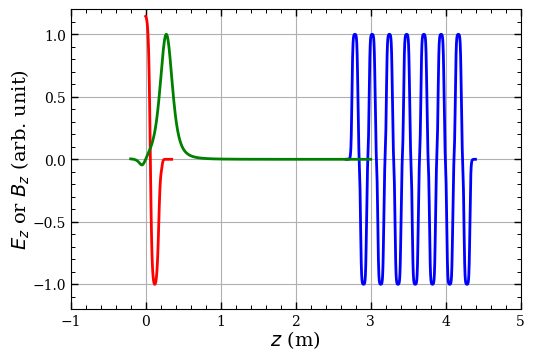

In [3]:
workdir = rootdir+r'\sync\field-maps'
os.chdir(workdir)

gun = np.loadtxt('gun45cavity.txt')
boo = np.loadtxt('CDS14_15mm.txt')
sol = np.loadtxt('gunsolenoidsPITZ.txt')

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(gun[:,0], gun[:,1], '-')
ax.plot(boo[:,0]+2.675, boo[:,1], '-')
ax.plot(sol[:,0], sol[:,1], '-')

ax.set_xlabel(u_z)
ax.set_ylabel(r'$E_z$ or $B_z$ (arb. unit)')
ax.set_xlim(-1, 5)
ax.set_ylim(-1.2, 1.2)

ax.grid()
fig.savefig('fields.eps')

## Solenoid current vs. magnetic field

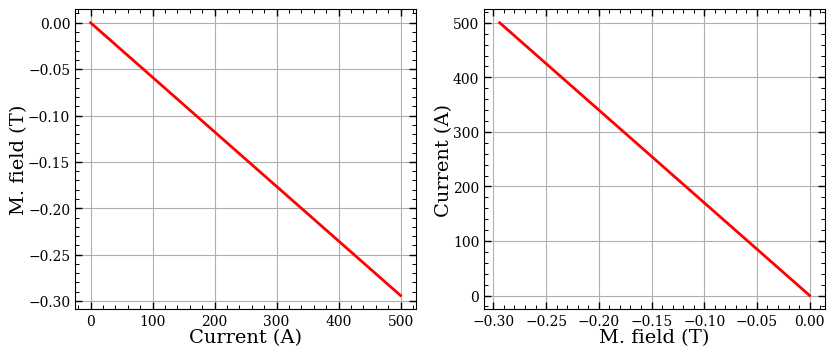

In [4]:
workdir = rootdir+r'\sync\results'
os.chdir(workdir)

I = np.linspace(0, 500, 101)
B = I2B(I)

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
ax[0].plot(I, B, '-')
ax[1].plot(B, I, '-')
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel(r'Current (A)')
ax[0].set_ylabel(r'M. field (T)')
ax[1].set_xlabel(r'M. field (T)')
ax[1].set_ylabel(r'Current (A)')
fig.savefig('solenoid.eps')

## Quadruple field

ratio of peak to effective gradients:  1.590444459638447


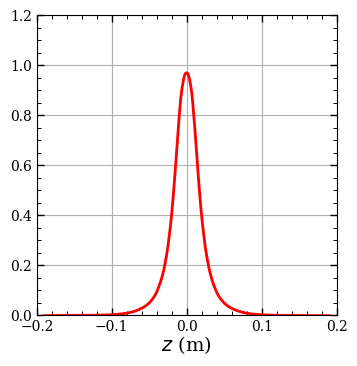

In [5]:
workdir = rootdir+r'\sync\field-maps'
os.chdir(workdir)

quad = np.loadtxt('Q3.data')
fig, ax = plt.subplots()
ax.plot(quad[:,0], quad[:,1], '-')

ax.set_xlabel(u_z)
# ax.set_ylabel(u_x)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(0, 1.2)
ax.grid()

eff_length = 0.067500 # in unit of meter, used in SCO software
eff_grad = np.sum(quad[:,1]*(quad[1,0]-quad[0,0]))/eff_length
print 'ratio of peak to effective gradients: ', np.max(quad[:,1])/eff_grad

## Aperture

(0, 20)

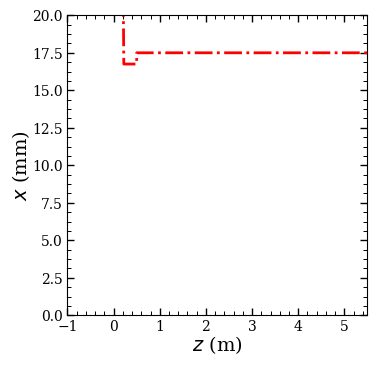

In [6]:
workdir = rootdir+r'\sync\field-maps'
os.chdir(workdir)

app = np.loadtxt('app.txt')
fig, ax = plt.subplots()
ax.plot(app[:,0], app[:,1], '-.')

ax.set_xlabel(u_z)
ax.set_ylabel(u_x)
ax.set_xlim(-1, 5.5)
ax.set_ylim(0, 20)

# Demo 

## plot: trajectories along $z$

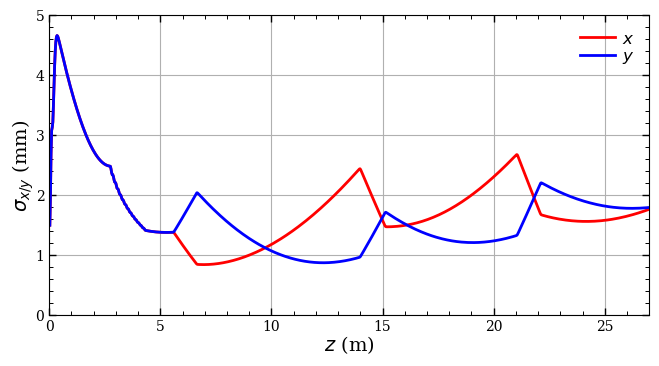

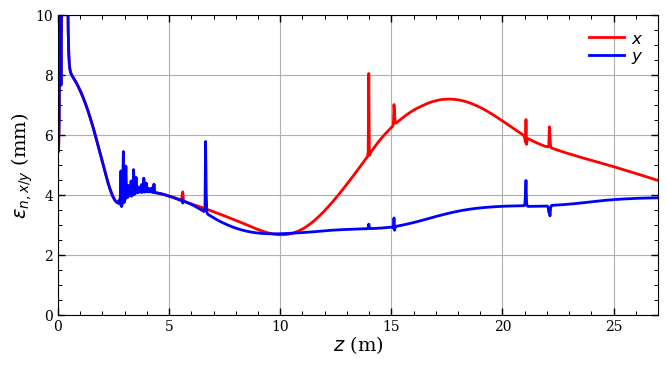

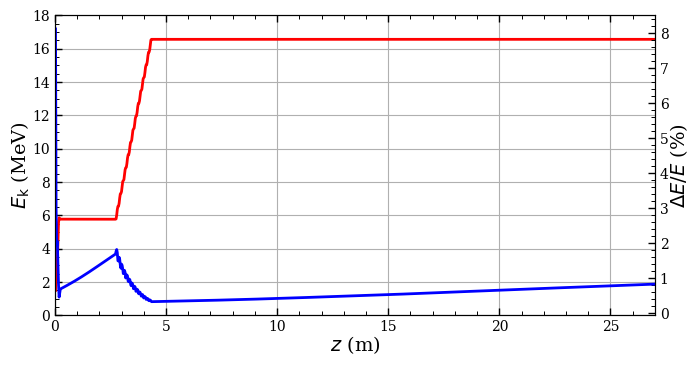

In [3]:
workdir = rootdir+r'\simul\EMSY1toWall\6quads\tmp2'
os.chdir(workdir)

fig_ext = '.eps'
prefix = 'pithz100um'
prefix = 'ast'
suffix = '001' # nmacro [k] + number of quads

xmin, xmax = 0, 27

#plot_avg_xy(prefix = prefix, suffix = suffix, extent = None, figsize=(8, 4))
plot_rms_xy(prefix = prefix, suffix = suffix, extent = [xmin, xmax, 0, 5], figsize=(8, 4))
plot_emi_xy(prefix = prefix, suffix = suffix, extent = [xmin, xmax, 0, 10], figsize=(8, 4))
plot_kin(   prefix = prefix, suffix = suffix, extent = [xmin, xmax, 0, 18], figsize=(8, 4))

## plot: phase space distributions

In [17]:
P0 = 17.05 # MeV/c
Ek = momentum2kinetic(P0) # MeV
gamma = kinetic2gamma(Ek) # 1
bg = gamma2bg(gamma); print bg

nemit_x, sigma_x = 4e-6, 0.18e-3
beta_x = sigma_x**2/(nemit_x/bg)
print beta_x

33.366017934337194
0.2702647452681313


In [4]:
from my_object import *
get_MaxE_booster(phi_gun = -2.286438E+00, phi_booster = -2.038065E+01)

13.156099569537437

In [6]:
def demo_beam(fname):
    beam = np.loadtxt(fname)
    beam[1:,2] += beam[0,2]; beam[1:,5] += beam[0,5]
    
    select = (beam[:,0]>-5.5e-3)*(beam[:,0]<5.5e-3)*(beam[:,1]>-2.5e-3)*(beam[:,1]<2.5e-3)
    beam = beam[select]
    
    values = astra_post(beam)
    
    keys = ['avg_z', 'nemit_x', 'nemit_y', 'std_x', 'std_y', 'std_z', 'Ekin', 'std_Ekin', 'nemit_z', 'Q_b',\
      'avg_x', 'avg_y', 'alpha_x', 'beta_x', 'gamma_x', 'emit_x', 'alpha_y', 'beta_y', 'gamma_y', 'emit_y',\
      'loss_cathode', 'loss_aperture']
    units = ['m', 'um', 'um', 'mm', 'mm', 'mm', 'MeV', 'keV', 'keV mm', 'pC',\
            'm', 'm', ' ', 'm', 'm^-1', 'm', ' ', 'm', 'm^-1', 'm', ' ', ' ']
    
    for i in np.arange(len(values)):
        print str('%15s: %15.6E %s' % (keys[i], values[i], units[i]))
    return

          avg_z:    5.280012E+00 m
        nemit_x:    3.912819E+00 um
        nemit_y:    3.899542E+00 um
          std_x:    1.380983E+00 mm
          std_y:    1.380962E+00 mm
          std_z:    2.479350E+00 mm
           Ekin:    1.655733E+01 MeV
       std_Ekin:    5.487800E+01 keV
        nemit_z:    1.293484E+02 keV mm
            Q_b:   -3.999880E+03 pC
          avg_x:    6.261399E-09 m
          avg_y:    7.198033E-09 m
        alpha_x:   -4.244683E-03  
         beta_x:    1.624498E+01 m
        gamma_x:    6.155860E-02 m^-1
         emit_x:    1.173971E-07 m
        alpha_y:   -6.221153E-03  
         beta_y:    1.629976E+01 m
        gamma_y:    6.135298E-02 m^-1
         emit_y:    1.169990E-07 m
         cor_Ek:   -1.308913E+01 keV
   loss_cathode:    0.000000E+00  
  loss_aperture:    0.000000E+00  


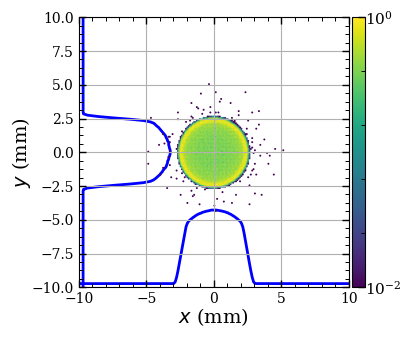

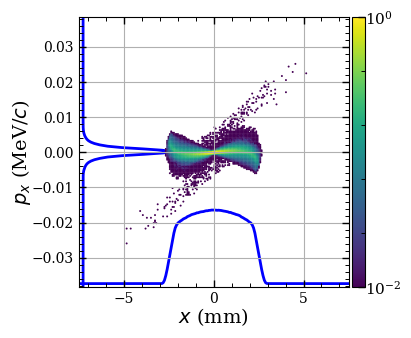

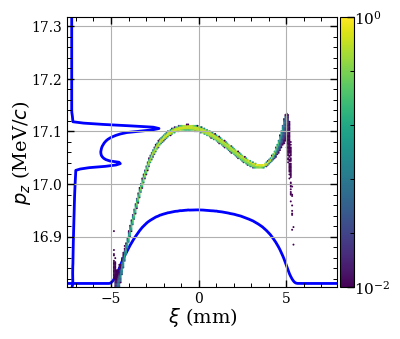

In [4]:
#workdir = rootdir + r'/simul/#320/SCO/tmp'
#os.chdir(workdir)

fig_ext = '.eps'
prefix = 'ast'
fname = prefix+'.0528.206'
#fname = 'beam_und.ini'

demo_beam(fname)

xmax = ymax = 10
plot2d_xy( fname, fig_ext = fig_ext, vmin = 0.01, bins = (200, 200), extent = [-xmax, xmax, -ymax, ymax])
plot2d_xpx(fname, fig_ext = fig_ext, vmin = 0.01, bins = (200, 200))
plot2d_zpz(fname, fig_ext = fig_ext, vmin = 0.01, bins = (200, 200))

## plot: trajectories along $z$ from SCOptimizer

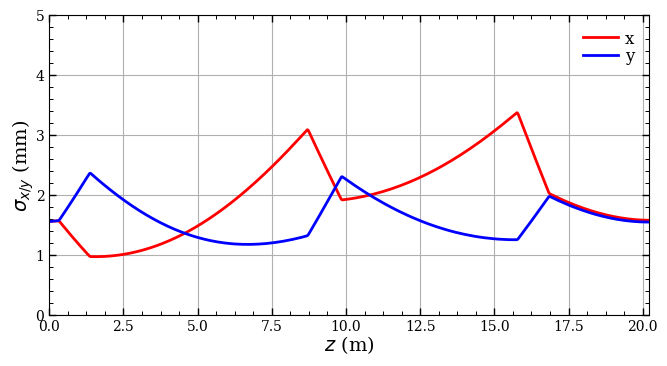

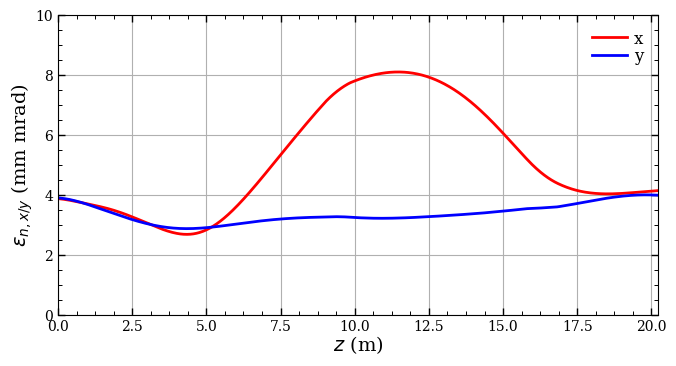

In [6]:
def plot_sco(fname = 'BeamDynamics.dat', x = 'avg_z', y = ['std_x', 'std_y'], xlabel = u_z, ylabel = u_rms_xy,\
             legends = ['x', 'y'], figname = 'sco-rms_xy-z', fig_ext = '.eps', extent = None, **kwargs):
    '''
    Parameters
      fname: the file name that stores the beam parameters
      x,y: specify which columns are to be plotted, could be string or list of strings:
           kv={'avg_z':0, 'nemit_x':1, 'nemit_y':2, 'std_x':3, 'std_y':4, 'std_z':5,\
               'beta_x':6, 'beta_y':7, 'alpha_x':8, 'alpha_y':9, 'r56':10, 'avg_p': 13}
      xlabel, ylabel: specify the labels of the plot
      legends: a list of strings, used only when y is also a list
      figname: specify the figure name to be saved
      fig_ext: specify the extension of the figure name
      **kwargs: to be passed to plt.subplots()
    '''
    kv={'avg_z':0, 'nemit_x':1, 'nemit_y':2, 'std_x':3, 'std_y':4, 'std_z':5, 'beta_x':6, 'beta_y':7,\
    'alpha_x':8, 'alpha_y':9, 'r56':10, 'avg_p': 13}

    data = np.loadtxt(fname)
    
    xd = data[:,kv[x]]
    fig, ax = plt.subplots(**kwargs)
    if isinstance(y, list):
        for i, yi in enumerate(y):
            yd = data[:,kv[yi]]
            ax.plot(xd, yd, '-', label = legends[i])
    else:
        yd = data[:,kv[y]]
        ax.plot(xd, yd, '-')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if extent is not None:
        xmin, xmax, ymin, ymax = extent
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    ax.grid()
    ax.legend()
    
    fig.savefig(figname+fig_ext)
    return

workdir = rootdir+r'\simul\#320\SCO\6quads'
#workdir = r'C:\Users\LiXK\Desktop\SCO'
os.chdir(workdir)

fname = 'BeamDynamics.dat'
#fname = 'LocalMinima/BeamDynamics1__.txt'
plot_sco(fname, extent = [0, 25.5-5.28, 0, 5], figsize=(8, 4))
plot_sco(fname, y = ['nemit_x', 'nemit_y'], ylabel = u_emi_xy, figname = 'sco-emi_xy-z',\
         extent = [0, 25.5-5.28, 0, 10], figsize=(8, 4))

# Energy gains in the gun and booster
## Scan of injection phase in the gun

<IPython.core.display.Javascript object>


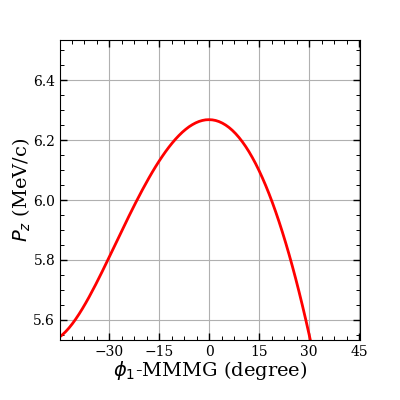

6.2678
-18.924973947489875


In [4]:
workdir = rootdir+r'\test-DE-MC'
os.chdir(workdir)

fig_ext = '.eps'

data = np.loadtxt('phi1_scan.dat')

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '-')
    
ax.set_xlabel(r'$\phi_1$-MMMG (degree)')
ax.set_ylabel(r'$P_z$ (MeV/c)')

ax.set_xlim(-45, 45)
ax.set_xticks(np.linspace(-45, 45, 7))
ax.set_ylim(5.5, 6.5)

ax.grid()
fig.savefig('pz-phi1'+fig_ext)

m1 = np.max(data[:,1]); print m1
m2 = 6.1
k1 = momentum2kinetic(m1)
gamma = kinetic2gamma(k1)
beta = gamma2beta(gamma)
print 1.71*(1-1./beta)/g_c*1e12

## Interpolation of energy gain vs. $E_{\rm boost}$ and $\phi_{\rm boost}$

In [3]:
workdir = rootdir+r'\test-DE-MC'
os.chdir(workdir)

data_gun = np.loadtxt('phi1_scan.dat')
fEG_gun = interp1d(data_gun[:,0], data_gun[:,1])

data_booster = np.loadtxt('phi2_scan.dat')
EG_booster = np.reshape(data_booster[:,2], (61, 71))-6.2678

phi_booster = np.linspace(-30, 30, 61)
E_booster   = np.linspace(10, 17, 71)

fEG_booster = interp2d(E_booster, phi_booster, EG_booster)

12.672392638


<IPython.core.display.Javascript object>


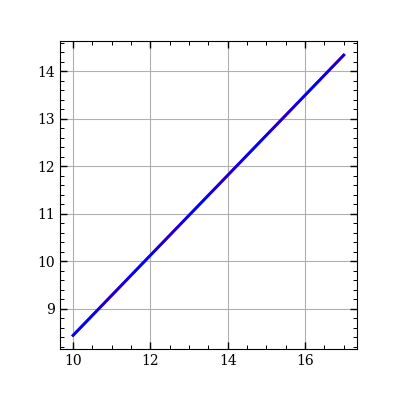

In [4]:
def get_MaxE_booster(MaxE_gun = 60, phi_gun = 0, phi_booster = 0):

    Eb = np.linspace(10, 17, 71*5)
    EG = fEG_booster(Eb, phi_booster)
    fEb_EG = interp1d(EG, Eb)

    MaxE_booster = fEb_EG(16.65-fEG_gun(phi_gun))
    return np.asscalar(MaxE_booster)
MaxE_booster = get_MaxE_booster(60, 0, -20.5)
print MaxE_booster

MaxE_gun, phi_gun, phi_booster = 60, 0, 15

Eb = np.linspace(10, 17, 71*5)
EG = fEG_booster(Eb, phi_booster)
fEb_EG = interp1d(EG, Eb)

fig, ax = plt.subplots()
ax.plot(Eb, EG, '-')
ax.plot(fEb_EG(EG), EG, '-')
ax.grid()

# Analyze: number of macro particles
## Plot: trajectories along $z$

In [5]:
workdir = rootdir+r'\test-DE-MC'
os.chdir(workdir)

fig_ext = '-np-I-350A.png'

v0 = 350
var_list = [8, 10, 50, 80, 100, 150, 200]
legend_list = [str.format('np = %d k' % var) for var in var_list]
fname_list = [str.format('n%dk-I-%.1fA' % (var, v0)) for var in var_list]

In [56]:
workdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\test-DE-MC'
os.chdir(workdir)

fig_ext = '-I-n100k.png'

Imain_list = [300, 350, 385.9, 400]
Ipart = 100
legend_list = [str.format('$I$ = %.0f A' % Imain) for Imain in Imain_list]
fname_list = [str.format('n%dk-I-%.1fA' % (Ipart, Imain)) for Imain in Imain_list]

<IPython.core.display.Javascript object>


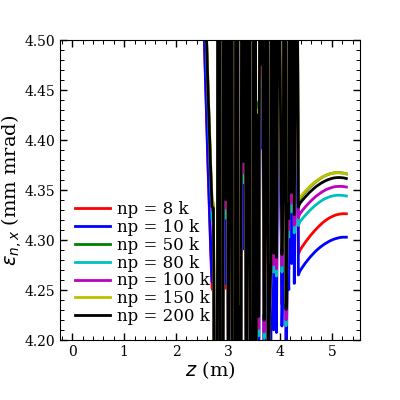

<IPython.core.display.Javascript object>


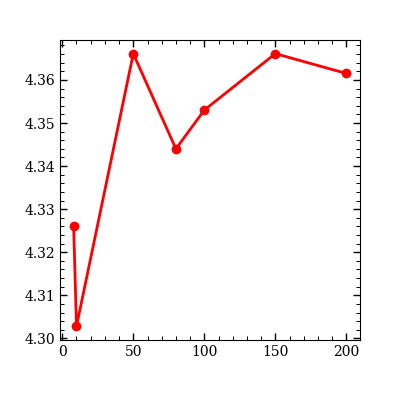

In [6]:
fig, ax = plt.subplots()

res =[]
for i, fname in enumerate(fname_list):  
    data = np.loadtxt(fname+'/ast.Xemit.001')
    ax.plot(data[:,0], data[:,5], '-', label = legend_list[i])
    res.append([var_list[i], get_nemixrms(fname+'/ast.Xemit.001')])
ax.set_xlabel(u_z)
ax.set_ylabel(u_emi_x)
ax.legend()
ax.set_ylim(4.2, 4.5)
fig.savefig('xemi-z'+fig_ext)

res = np.array(res)
fig, ax = plt.subplots()
ax.plot(res[:,0], res[:,1])

<IPython.core.display.Javascript object>


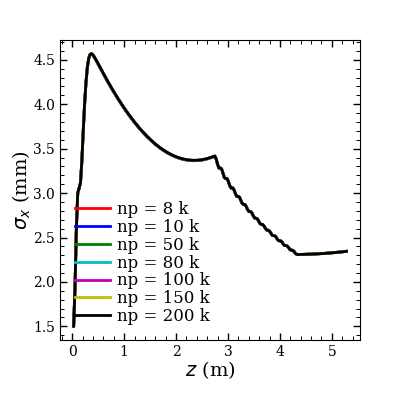

In [7]:
fig, ax = plt.subplots()

for i, fname in enumerate(fname_list):  
    data = np.loadtxt(fname+'/ast.Xemit.001')
    ax.plot(data[:,0], data[:,3], '-', label = legend_list[i])

ax.set_xlabel(u_z)
ax.set_ylabel(u_rms_x)
ax.legend()

fig.savefig('xrms-z'+fig_ext)

<IPython.core.display.Javascript object>


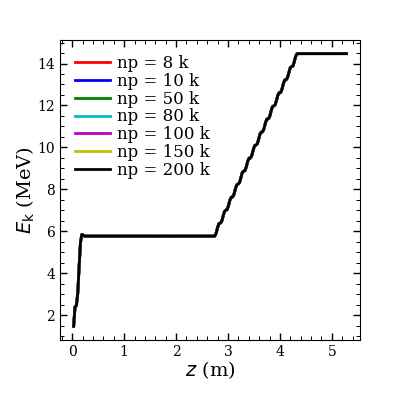

In [8]:
fig, ax = plt.subplots()

for i, fname in enumerate(fname_list):  
    data = np.loadtxt(fname+'/ast.Zemit.001')
    ax.plot(data[:,0], data[:,2], '-', label = legend_list[i])

ax.set_xlabel(u_z)
ax.set_ylabel(u_kinetic)
ax.legend()

fig.savefig('Ekin-z'+fig_ext)

<IPython.core.display.Javascript object>


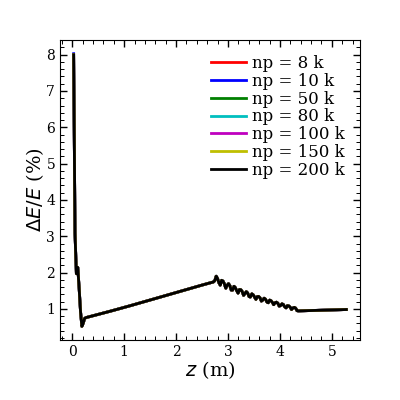

In [9]:
fig, ax = plt.subplots()

for i, fname in enumerate(fname_list):  
    data = np.loadtxt(fname+'/ast.Zemit.001')
    ax.plot(data[:,0], data[:,4]/data[:,2]/10, '-', label = legend_list[i])

ax.set_xlabel(u_z)
ax.set_ylabel(u_rel_kinetic)
ax.legend()

fig.savefig('Ekin_rel-z'+fig_ext)

# Preliminary optimization from cathode to EMSY1

In [72]:
def find(fname, target='z<Zmin'):
    datafile = file(fname)
    found = False
    for line in datafile:
        if target in line:
            found = True
            return line
    return None

In [33]:
workdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\simul\EMSY1'
os.chdir(workdir)

start_line = 0
data = np.loadtxt('results.dat', skiprows = start_line)

for i, line in enumerate(data):
    Ipart, D, MaxE_gun, phi_gun, MaxE_booster, phi_booster, Imain = line[0:7]; sigma_x = D/4.
    direc = str.format('n%.0fk-D-%.2fmm-E1-%.2fMV_m-phi1-%.2fdeg-E2-%.2fMV_m-phi2-%.2fdeg-I-%.2fA' %\
                        (Ipart/1000., sigma_x*4, MaxE_gun, phi_gun, MaxE_booster, phi_booster, Imain))
    try:
        fname = direc+'/ast.0528.001'
        beam = np.loadtxt(fname)
        beam[1:,2] += beam[0,2]; beam[1:,5] += beam[0,5]
        tmp = astra_post(beam); #print direc, '\n', tmp, tmp[1]
        with open('results.post.dat', 'a') as f_handle:
            np.savetxt(f_handle,np.atleast_2d(np.concatenate(([i+start_line], line[0:7], tmp))),fmt='%15.6E')
    except IOError:
        print fname, ' not found'

n50k-D-3.67mm-E1-60.00MV_m-phi1--6.43deg-E2-13.07MV_m-phi2--18.97deg-I-364.11A/ast.0528.001  not found
n50k-D-3.53mm-E1-60.00MV_m-phi1--5.62deg-E2-12.80MV_m-phi2--15.18deg-I-367.57A/ast.0528.001  not found
n50k-D-3.52mm-E1-60.00MV_m-phi1--7.58deg-E2-13.42MV_m-phi2--22.82deg-I-366.61A/ast.0528.001  not found
n50k-D-3.56mm-E1-60.00MV_m-phi1--6.94deg-E2-13.40MV_m-phi2--22.72deg-I-365.08A/ast.0528.001  not found
n50k-D-3.40mm-E1-60.00MV_m-phi1--6.86deg-E2-13.29MV_m-phi2--21.56deg-I-365.44A/ast.0528.001  not found
n50k-D-3.49mm-E1-60.00MV_m-phi1--5.10deg-E2-12.49MV_m-phi2--8.33deg-I-367.61A/ast.0528.001  not found
n50k-D-3.45mm-E1-60.00MV_m-phi1--6.81deg-E2-13.16MV_m-phi2--20.00deg-I-365.69A/ast.0528.001  not found
n50k-D-3.43mm-E1-60.00MV_m-phi1--6.04deg-E2-12.64MV_m-phi2--11.95deg-I-367.05A/ast.0528.001  not found


In [5]:
workdir = rootdir + r'\sync\results'
os.chdir(workdir)

In [3]:
workdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\simul\EMSY1'
os.chdir(workdir)

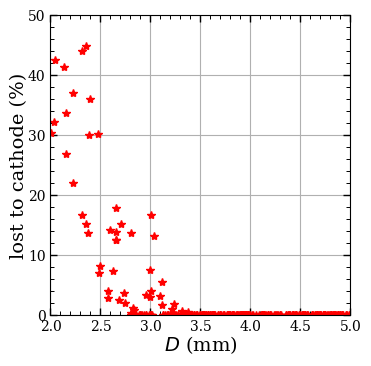

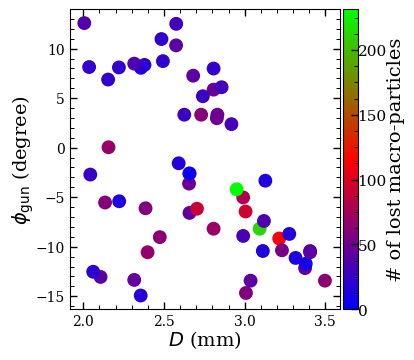

In [4]:
res = np.loadtxt('results2.dat')

start = 8

fig, ax = plt.subplots()
ax.plot(res[:,2], res[:,start+21]/5e4*100., '*')
ax.grid()
ax.set_xlim(2, 5)
ax.set_ylim(0, 50)
ax.set_xlabel(r'$D$ (mm)')
ax.set_ylabel(r'lost to cathode (%)')

fig.savefig('beam-loss-to-cathode.eps')

select = (res[:,start+21]>0)
res=res[select]; #print res.shape; print res

fig, ax = plt.subplots()

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,21]
cax = ax.scatter(res[:,2], res[:,4], s=[10*2**3 for n in cs],\
                 vmin=0, c=cs, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
#cbar.set_ticks([3, 3.2, 3.4, 3.6, 3.8, 4])
cbar.ax.tick_params(labelsize=11, pad=0)
cbar.ax.set_ylabel(r'# of lost macro-particles')

ax.set_xlabel(r'$D$ (mm)')
ax.set_ylabel(r'$\phi_{\rm gun}$ (degree)')
fig.savefig('beam-loss-phi1-vs-D.eps')

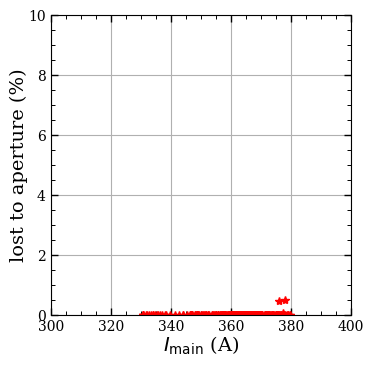

In [103]:
res = np.loadtxt('results.post.dat')

start = 8

#select = (res[:,start+22]<=0)
#res=res[select];

fig, ax = plt.subplots()
ax.plot(res[:,7], res[:,start+22]/5e4*100., '*')
ax.grid()
ax.set_xlim(300, 400)
ax.set_ylim(0, 10)
ax.set_xlabel(r'$I_{\rm main}$ (A)')
ax.set_ylabel(r'lost to aperture (%)')

fig.savefig('beam-loss-to-aperture.eps')

## Filter by emittance only

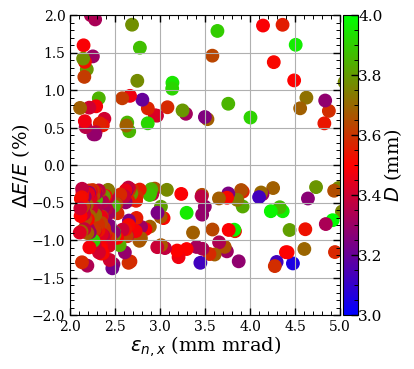

In [114]:
res = np.loadtxt('results.post.dat')

start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,2]>3)*(res[:,2]<4)
res=res[select]; #print res.shape; print res

fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,2]
cax = ax2.scatter(res[:,start+1], res[:,start+7]/res[:,start+6]/10*np.sign(res[:,start+20]),\
                  s=[10*2**3 for n in cs], c=cs, vmin=3, vmax=4, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks([3, 3.2, 3.4, 3.6, 3.8, 4])
cbar.ax.tick_params(labelsize=11, pad=0)
cbar.ax.set_ylabel(r'$D$ (mm)')

ax2.grid()
ax2.set_xlim(2, 5)
ax2.set_ylim(-2, 2)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_kinetic_rel)

#plt.tight_layout()

fig.savefig('Xemi-Erms-D.eps')

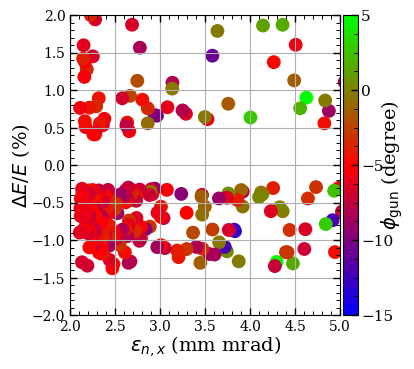

In [51]:
fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,4]
cax = ax2.scatter(res[:,start+1], res[:,start+7]/res[:,start+6]/10*np.sign(res[:,start+20]),\
                  s=[10*2**3 for n in cs], c=cs, vmin=-15, vmax=5, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks(np.linspace(-15, 5, 5))
cbar.ax.tick_params(labelsize=11, pad=2)
cbar.ax.set_ylabel(r'$\phi_{\rm gun}$ (degree)', labelpad=-10)

ax2.grid()
ax2.set_xlim(2, 5)
ax2.set_ylim(-2, 2)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_kinetic_rel)

#plt.tight_layout()

fig.savefig('Xemi-Erms-phi_1.eps')

Text(0,0.5,'$\\varepsilon_{n,x}$ (mm mrad)')

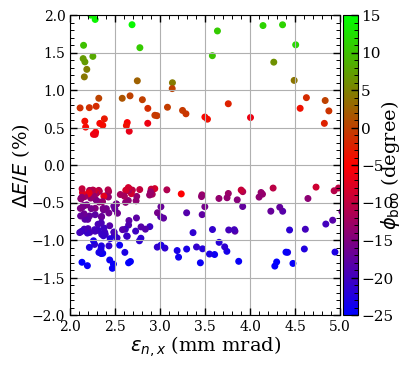

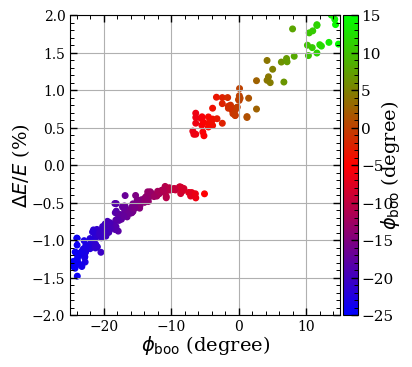

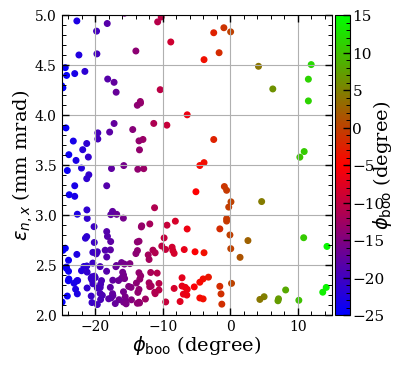

In [70]:
fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,6]
cax = ax2.scatter(res[:,start+1], res[:,start+7]/res[:,start+6]/10*np.sign(res[:,start+20]),\
                  s=[2*2**3 for n in cs], c=cs, vmin=-25, vmax=15, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks(np.linspace(-25, 15, 9))
cbar.ax.tick_params(labelsize=11, pad=2)
cbar.ax.set_ylabel(r'$\phi_{\rm boo}$ (degree)', labelpad=-10)

ax2.grid()
ax2.set_xlim(2, 5)
ax2.set_ylim(-2, 2)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_kinetic_rel)

#plt.tight_layout()

fig.savefig('Xemi-Erms-phi_2.eps')

fig, ax2 = plt.subplots()

cax = ax2.scatter(cs, res[:,start+7]/res[:,start+6]/10*np.sign(res[:,start+20]),\
                  s=[2*2**3 for n in cs], c=cs, vmin=-25, vmax=15, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks(np.linspace(-25, 15, 9))
cbar.ax.tick_params(labelsize=11, pad=2)
cbar.ax.set_ylabel(r'$\phi_{\rm boo}$ (degree)', labelpad=-10)

ax2.grid()
ax2.set_xlim(-25, 15)
ax2.set_ylim(-2, 2)
ax2.set_xlabel(r'$\phi_{\rm boo}$ (degree)')
ax2.set_ylabel(u_kinetic_rel)

fig, ax2 = plt.subplots()

cax = ax2.scatter(cs, res[:,start+1],\
                  s=[2*2**3 for n in cs], c=cs, vmin=-25, vmax=15, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks(np.linspace(-25, 15, 9))
cbar.ax.tick_params(labelsize=11, pad=2)
cbar.ax.set_ylabel(r'$\phi_{\rm boo}$ (degree)', labelpad=-10)

ax2.grid()
ax2.set_xlim(-25, 15)
ax2.set_ylim(2, 5)
ax2.set_xlabel(r'$\phi_{\rm boo}$ (degree)')
ax2.set_ylabel(u_emi_x)

## Filter together with energy chirp (negative)

Text(0,0.5,'$\\langle E_k z \\rangle/\\sigma_z$ (keV)')

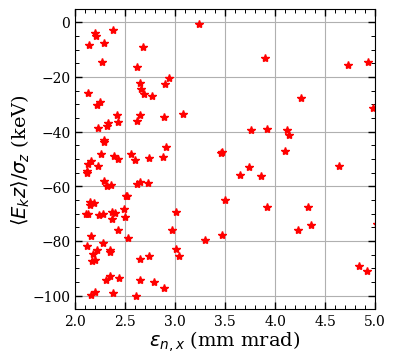

In [118]:
start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,2]>3)*(res[:,2]<4)*(res[:,start+20]<0)*(res[:,start+20]>-100)
res=res[select]; #print res.shape; print res

fig, ax = plt.subplots()
ax.plot(res[:,start+1], res[:,start+20], '*')
ax.grid()

ax.set_xlim(2, 5)
# ax.set_ylim(0, 50)
ax.set_xlabel(u_emi_x)
ax.set_ylabel(r'$\langle E_k z \rangle/\sigma_z$ (keV)')

#fig.savefig('beam-loss-to-cathode.eps')

(58L, 31L)


Text(0,0.5,'$\\Delta E/E$ (%)')

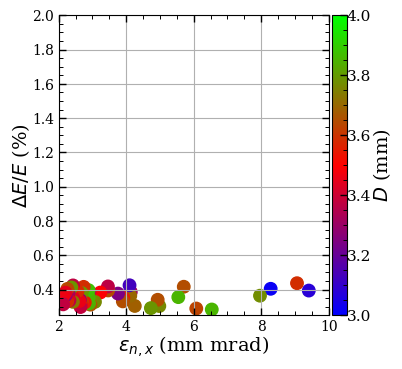

In [120]:
start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,2]>3)*(res[:,2]<4)*(res[:,start+20]<0)*(res[:,start+20]>-50)
res=res[select]; print res.shape; #print res

fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,2]
cax = ax2.scatter(res[:,start+1], res[:,start+7]/res[:,start+6]/10, s=[10*2**3 for n in cs],\
                  c=cs, vmin=3, vmax=4, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks([3, 3.2, 3.4, 3.6, 3.8, 4])
cbar.ax.tick_params(labelsize=11, pad=0)
cbar.ax.set_ylabel(r'$D$ (mm)')

ax2.grid()
ax2.set_xlim(2, 10)
ax2.set_ylim(0.25, 2)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_kinetic_rel)

#plt.tight_layout()

#fig.savefig('Xemi-Erms-D-Ekz.eps')

## Filter also with the Twiss parameter $\gamma$

(35L, 31L)
[[ 7.900000e+01  5.000000e+04  3.581141e+00 ... -1.334779e+02
   0.000000e+00  0.000000e+00]
 [ 8.300000e+01  5.000000e+04  3.501037e+00 ... -1.253537e+02
   0.000000e+00  0.000000e+00]
 [ 8.900000e+01  5.000000e+04  3.281373e+00 ... -1.382802e+02
   0.000000e+00  0.000000e+00]
 ...
 [ 3.930000e+02  5.000000e+04  3.501021e+00 ... -1.120307e+02
   0.000000e+00  0.000000e+00]
 [ 4.060000e+02  5.000000e+04  3.482855e+00 ... -1.020822e+02
   0.000000e+00  0.000000e+00]
 [ 4.110000e+02  5.000000e+04  3.255594e+00 ... -9.361016e+01
   0.000000e+00  0.000000e+00]]


Text(0,0.5,'$\\gamma$ (m$^{-1}$)')

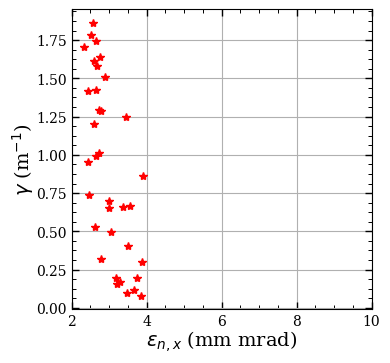

In [5]:
res = np.loadtxt('results.post.dat')

start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,2]>3)*(res[:,2]<4)
select *= (res[:,start+1]<4)
select *= (res[:,start+20]<-50)*(res[:,start+20]>-150)*(res[:,start+14]<2)

res=res[select]; print res.shape; print res
np.savetxt('selected.dat', res, fmt = '%15.6E')

fig, ax = plt.subplots()
ax.plot(res[:,start+1], res[:,start+14], '*')
ax.grid()

ax.set_xlim(2, 10)
# ax.set_ylim(0, 50)
ax.set_xlabel(u_emi_x)
ax.set_ylabel(r'$\gamma$ (m$^{-1}$)')

#fig.savefig('beam-loss-to-cathode.eps')

Text(0,0.5,'$\\Delta E/E$ (%)')

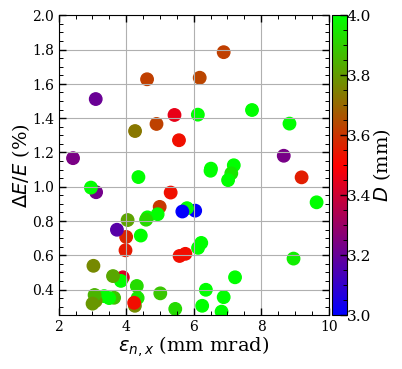

In [38]:
res = np.loadtxt('results2.dat')

start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,start+20]<0)*(res[:,start+14]<3)
res=res[select]; #print res.shape; print res

fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,2]
cax = ax2.scatter(res[:,start+1], res[:,start+7]/res[:,start+6]/10, s=[10*2**3 for n in cs],\
                  c=cs, vmin=3, vmax=4, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks([3, 3.2, 3.4, 3.6, 3.8, 4])
cbar.ax.tick_params(labelsize=11, pad=0)
cbar.ax.set_ylabel(r'$D$ (mm)')

ax2.grid()
ax2.set_xlim(2, 10)
ax2.set_ylim(0.25, 2)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_kinetic_rel)

#plt.tight_layout()

#fig.savefig('Xemi-Erms-D-Ekz-gamma2.eps')

## Filter out very small energy spread

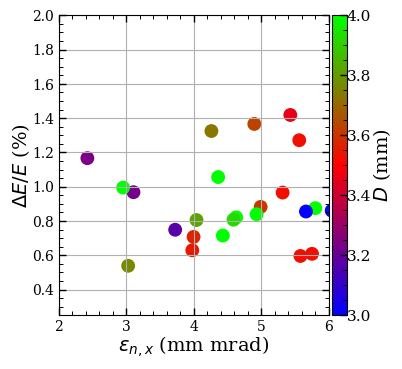

In [50]:
res = np.loadtxt('results1.dat')

start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,start+20]<0)*\
         (res[:,start+14]<3)*(res[:,start+7]/res[:,start+6]/10>0.5)*\
         (res[:,start+7]/res[:,start+6]/10<1.5)
res=res[select]; #print res.shape; print res

fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,2]
cax = ax2.scatter(res[:,start+1], res[:,start+7]/res[:,start+6]/10, s=[10*2**3 for n in cs],\
                  c=cs, vmin=3, vmax=4, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks([3, 3.2, 3.4, 3.6, 3.8, 4])
cbar.ax.tick_params(labelsize=11, pad=0)
cbar.ax.set_ylabel(r'$D$ (mm)')

ax2.grid()
ax2.set_xlim(2, 6)
ax2.set_ylim(0.25, 2)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_kinetic_rel)

#plt.tight_layout()

fig.savefig('Xemi-Erms-D-Ekz-gamma3-stdE.eps')

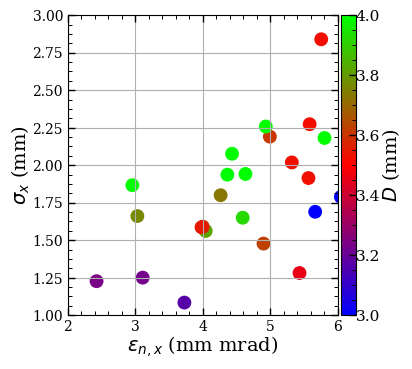

In [51]:
workdir = rootdir + r'\sync\results'
os.chdir(workdir)

res = np.loadtxt('results1.dat')

start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,start+20]<0)*\
         (res[:,start+14]<3)*(res[:,start+7]/res[:,start+6]/10>0.5)*\
         (res[:,start+7]/res[:,start+6]/10<1.5)
res=res[select]; #print res.shape; print res

fig, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

res = res[(res[:,start+1]).argsort()[::-1]]; cs = res[:,2]
cax = ax2.scatter(res[:,start+1], res[:,start+3], s=[10*2**3 for n in cs],\
                  c=cs, vmin=3, vmax=4, cmap='brg')
cbar = fig.colorbar(cax, fraction=0.09, pad=0.01)
cbar.set_ticks([3, 3.2, 3.4, 3.6, 3.8, 4])
cbar.ax.tick_params(labelsize=11, pad=0)
cbar.ax.set_ylabel(r'$D$ (mm)')

ax2.grid()
ax2.set_xlim(2, 6)
ax2.set_ylim(1, 3)
ax2.set_xlabel(u_emi_x)
ax2.set_ylabel(u_rms_x)

#plt.tight_layout()

fig.savefig('Xemi-xrms-D-Ekz-gamma3-stdE.eps')

In [6]:
workdir = rootdir + r'\sync\results'
workdir = r'E:\Bitbucket\pitz-work\results'
os.chdir(workdir)

res = np.loadtxt('results2.dat')

start = 8

select = (res[:,start+21]==0)*(res[:,start+22]==0)*(res[:,start+20]<0)*\
         (res[:,start+14]<3)*(res[:,start+7]/res[:,start+6]/10>0.75)*\
         (res[:,start+7]/res[:,start+6]/10<1.05)
select = select*(res[:,start+1]>3.8)*(res[:,start+1]<4.2)*(res[:,2]>3)*(res[:,2]<=4)

res=res[select]; print res.shape; print res

(1, 31)
[[  3.20000000e+02   5.00000000e+04   3.81932000e+00   6.00000000e+01
   -2.28643800e+00   1.26671000e+01  -2.03806500e+01   3.55701600e+02
    5.27992200e+00   4.04168000e+00   4.03258100e+00   1.56194800e+00
    1.56159900e+00   2.39102700e+00   1.62173700e+01   1.30603200e+02
    1.22117300e+02  -3.99952000e+03   4.21108400e-08  -1.26443900e-07
   -3.73305400e-01   1.96740500e+01   5.79116600e-02   1.24005000e-07
   -3.72459600e-01   1.97129700e+01   5.77653300e-02   1.23704900e-07
   -1.20202900e+02   0.00000000e+00   0.00000000e+00]]


# Generating 3D EM fields as Astra input

In [34]:
class Field3D():
    def __init__(self, dx, dy, dz, zmin, zmax, xmax, ymax = None, EM3D = None):
        '''
        Parameters:
          dx, dy, dz: grid sizes
          zmin, zmax: starting and end points of the area longitudinally
          rmax: half width of area transversely
          xmax, ymax: if not rotationally symmetric, use xmax and ymax to specify the width
                      and height of the area
          EM3D(x, y, z, t): the field interpolation function
        '''
        self.dx = dx; self.dy = dy; self.dz = dz
        self.zmin = zmin; self.zmax = zmax; self.xmax = xmax
        if ymax is None or 0:
            self.ymax = xmax
        else:
            self.ymax = ymax
        if EM3D is not None:
            self.EM3D = EM3D
    def build(self, EM3D = None):
        '''
        Parameters:
          EM3D(x, y, z, t): the field interpolation function
        '''
        if EM3D is not None:
            self.EM3D = EM3D
        else:
            def EM3D(x, y, z, t=0):
                return [0, 0, 0, 0, 0, 0]
        return
    def export_3D(self, fname = 'field3D', ext= ['.ex', '.ey', '.ez', '.bx', '.by', '.bz'], t=0):
        ext = ext
        ext_index={'.ex':0, '.ey':1, '.ez':2, '.bx':3, '.by':4, '.bz':5}
        
        dx, dy, dz = self.dx, self.dy, self.dz
        xwidth = self.xmax*2; ywidth = self.ymax*2; zlength = self.zmax-self.zmin
        Nx = int(xwidth/dx+1); Ny = int(ywidth/dy+1); Nz = int(zlength/dz+1)
        
        xx = np.linspace(-self.xmax, self.xmax, Nx)
        yy = np.linspace(-self.ymax, self.ymax, Ny)
        zz = np.linspace(0, zlength, Nz)
        
        for i, v in enumerate(ext):
            rr = np.concatenate(([len(xx)], xx))
            with open(fname+v,'w') as f_handle:
                np.savetxt(f_handle, rr.reshape(1, len(rr)), fmt='%15.6E')
            rr = np.concatenate(([len(yy)], yy))
            with open(fname+v,'a') as f_handle:
                np.savetxt(f_handle, rr.reshape(1, len(rr)), fmt='%15.6E')
            rr = np.concatenate(([len(zz)], zz))
            with open(fname+v,'a') as f_handle:
                np.savetxt(f_handle, rr.reshape(1, len(rr)), fmt='%15.6E')
        
        for z1 in zz:
            for y1 in yy:
                ff = []
                for x1 in xx:
                    f1 = self.EM3D(x1, y1, z1, t)
                    ff.append(f1)
                ff = np.array(ff)
                for v in ext:
                    l = ext_index[v]
                    rr = ff[:,l].T
                    with open(fname+v,'a') as f_handle:
                        np.savetxt(f_handle, rr.reshape(1, len(rr)), fmt='%15.6E')

1.2799839
1.199747284994933


Text(0,0.5,'$(a_n^2+b_n^2)^{1/2}$')

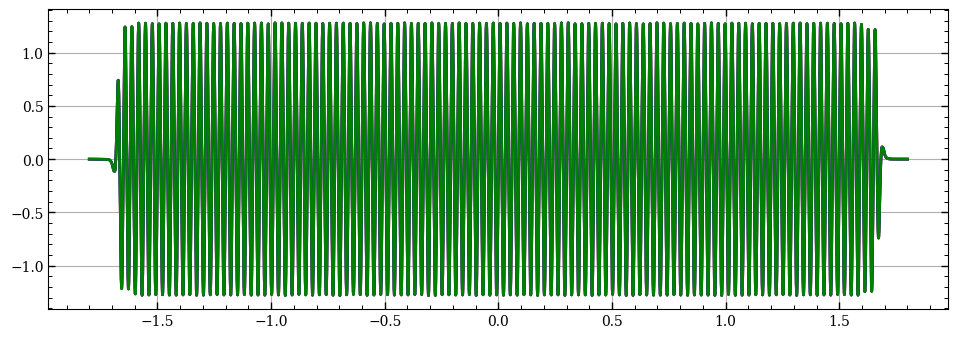

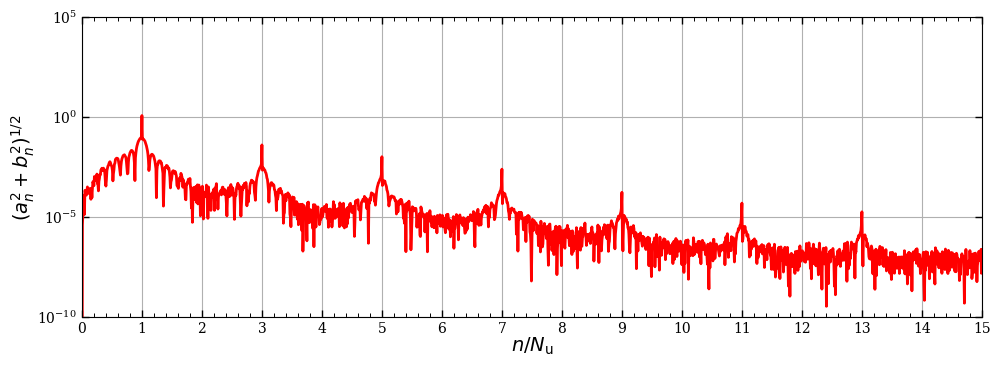

In [34]:
workdir = rootdir+r'\simul\LCLS-1 undulator fields'
os.chdir(workdir)

NumberOfHarmonics = 15
# set the undulator parameters
N_u = 120; lam_u = 0.03; L_u = N_u*lam_u

data = np.loadtxt('slacBySym6.txt')
z = data[:,0]; By = data[:,1]; dz = z[1]-z[0]

# find the rough center
z0 = np.sum(z*np.abs(By))/np.sum(np.abs(By))
z = z-z0

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(z, By, '-')
ax.grid()
#ax.set_xlim(-1.8, -1.0)

print np.max(By)

# find exact center where By=0
index, tmp = index_min(np.abs(z))
Nz_quater = int(lam_u/4./dz)
fz_By = interp1d(By[index-Nz_quater:index+Nz_quater], z[index-Nz_quater:index+Nz_quater])
z00 = fz_By(0)
z = z-z00

ax.plot(z, By, '-')
#ax.set_xlim(-0.01, 0.01)

select = (z<=L_u/2.)*(z>=-L_u/2.)
z = z[select]
By = By[select]

ax.plot(z, By, '-')

# Fourier analysis
nharm = np.arange(0, N_u*NumberOfHarmonics+1)

k_n = 2.*np.pi*nharm/L_u

xi = 0
ky_n = k_n/np.sqrt(1+xi**2)
kx_n = xi*ky_n

a_0 = np.sum(By*dz)/L_u; #print a_0
#b_0 = 0

a_n = [2./L_u*np.sum(By*np.cos(k_n[i]*z)*dz) for i in nharm]
b_n = [2./L_u*np.sum(By*np.sin(k_n[i]*z)*dz) for i in nharm]
    
a_n = np.array(a_n); a_n[0] = a_n[0]/2.; #print a_n[0]
b_n = np.array(b_n); #print b_n[0]

np.savetxt('spectrum.dat', np.array([nharm, a_n, b_n]).T, fmt = '%15.6E')
print np.sqrt(np.sum((a_n**2+b_n**2))) #*120/113.

spectrum = np.sqrt(a_n**2+b_n**2)

fig, ax = plt.subplots(figsize = (12,4))
ax.plot(1.0*nharm/N_u, spectrum, '-')
ax.set_yscale('log')
ax.set_xlim(0, 15)
ax.set_xticks(np.arange(16))
ax.set_ylim(1e-10, 1e5)
ax.set_yticks([1e-10, 1e-5, 1e0, 1e5])
ax.grid()
ax.set_xlabel(r'$n/N_{\rm u}$')
ax.set_ylabel(r'$(a_n^2+b_n^2)^{1/2}$')

In [37]:
a_n[0] = 0
def EM3D(x, y, z, t=0):
    Ex, Ey, Ez = 0, 0, 0
    Bx, By, Bz = 0, 0, 0
    By = np.sum(( a_n*np.cos(k_n*z)+b_n*np.sin(k_n*z))*np.cosh(k_n*y))
    Bz = np.sum((-a_n*np.sin(k_n*z)+b_n*np.cos(k_n*z))*np.sinh(k_n*y))
    return [Ex, Ey, Ez, Bx, By, Bz]

z1 = z
By1 = [EM3D(0, 0, zi)[4] for zi in z1]; print np.max(By1)

1.2799855353434733


(-1.5, -1.41)

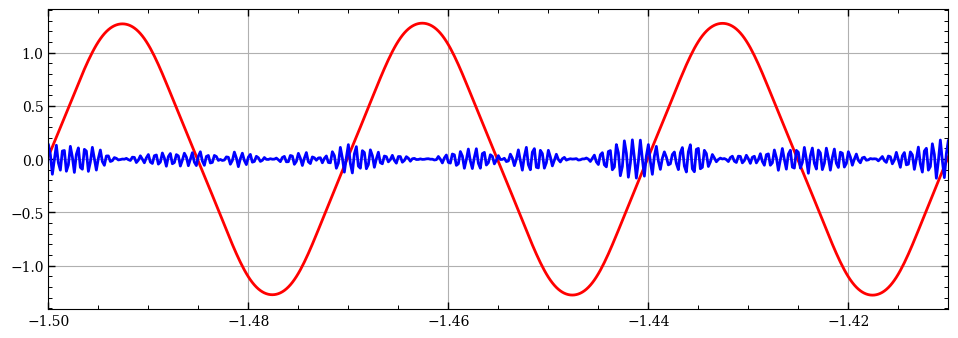

In [43]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(z, By, '-')
ax.plot(z1, (By1-By)*1e3, '-')
ax.grid()
ax.set_xlim(-1.50, -1.41)

In [31]:
workdir = r'C:\Users\lixiangk\Desktop\tmp'
os.chdir(workdir)

In [ ]:
Xmax, Ymax = 6e-3, 3e-3
Nx, Ny = 6, 3
dx, dy = Xmax/Nx, Ymax/Ny
undul = Field3D(dx, dy, dz, -L_u/2., L_u/2., Xmax, Ymax, EM3D)
undul.export_3D('und3D', ext = ['.bx', '.by', '.bz'])

In [ ]:
workdir = rootdir + r'/simul/test-undulator-2'
os.chdir(workdir)

start_line = 256
data = np.loadtxt('results1.dat', skiprows = start_line)

for i, line in enumerate(data):
    #print line
    Ipart, sigma_x, sigma_y, alpha_x, alpha_y = line[0:-1]
    direc = str.format('n%.0fk-sig_x-%.2fmm-sig_y-%.2fmm-alp_x-%.2f-alp_y-%.2f' %\
                        (Ipart/1000., sigma_x, sigma_y, alpha_x, alpha_y))
    try:
        fname = direc+'/ast.0380.001'
        beam = np.loadtxt(fname)
        beam[1:,2] += beam[0,2]; beam[1:,5] += beam[0,5]
        tmp = astra_post(beam); #print direc, '\n', tmp, tmp[1]
        with open('results10.dat', 'a') as f_handle:
            np.savetxt(f_handle,np.atleast_2d(np.concatenate(([i+start_line], line[0:7], tmp))),fmt='%15.6E')
        #if line[-1]>50:
        #    cmd = 'rm -R '+direc
        #    #print direc#, cmd
        #    os.system(cmd)
    except IOError:
        print fname, ' not found'

## Phase integral

In [143]:
def first_integral(z, fBy_z, L, z0 = None):
    '''
    First integral
    Parameters
      z0, z: longitudinal range which is concerned
      fBy_z: magnetic field component Bz as a function of z, fBy_z = f(z)
    Returns
      I1: first integral at z
    '''
    if z0 is None:
        z0 = -L/2.
    ans, err = quad(fBy_z, z0, z)
    return ans
def first_integral_z(fBy_z, L, z0 = None, Nz = 1001):
    '''
    First integral as function of z
    Parameters
      fBz_z: magnetic field component Bz as a function of z, fBz = f(z)
      L: undulator length
    Returns
      fI1_z: first integral as a function of z
    '''
    if z0 is None:
        z0 = -L/2.
    zz = np.linspace(z0, z0+L, Nz); dz = zz[1]-zz[0]
    I1 = np.zeros(len(zz))
    
    for i in np.arange(1, len(zz)):
        zi = zz[i]
        I1[i] = I1[i-1]+first_integral(zi, fBy_z, L, z0 = zi-dz)
    f = interp1d(zz, I1, bounds_error = None, fill_value = 0)
    
    return f

def second_integral(z, fI1_z, L, z0 = None):
    '''
    Second Integral
    Parameters
      z0, z1: longitudinal range which is concerned
      fI1_z: first integral as a function of z, fI1_z = f(z)
      L: undulator length
    Returns
      I2: phase integral at z
    '''
    if z0 is None:
        z0 = -L/2.
    ans, err = quad(fI1_z, z0, z, limit = 100)
    return ans
def second_integral_z(fI1_z, L, z0 = None, Nz = 1001):
    '''
    Phase advance as a function of z
    Parameters
      fI1_z: first integral as a function of z, fI1_z = f(z)
      L: undulator length
      K: undulator parameter
      lam_u: undulator period
    Returns
      fI2_z: second integral as a function of z
    '''
    if z0 is None:
        z0 = -L/2.
    zz = np.linspace(z0, z0+L, Nz); dz = zz[1]-zz[0]
    I2 = np.zeros(len(zz))
    
    for i in np.arange(1, len(zz)):
        zi = zz[i]
        I2[i] = I2[i-1] + second_integral(zi, fI1_z, L, z0 = zi-dz)
    f = interp1d(zz, I2, bounds_error = None, fill_value = 0)
    
    return f

def phase_integral0(z, fBy_z, L):
    '''
    Phase Integral
    Parameters
      z: longitudinal coordinate where the phase advance is concerned
      fBy_z: magnetic field component Bz as a function of z, fBy_z = f(z)
    Returns
      PI: phase integral at z
    '''
    def integrand(z):
        I1 = first_integral(z, fBy_z, L)
        return I1**2
    ans, err = quad(integrand, -L/2., z)
    return ans
def phase_integral(z, fI1_z, L, z0 = None):
    '''
    Phase Integral
    Parameters
      z0, z1: longitudinal range which is concerned
      fI1_z: first integral as a function of z, fI1_z = f(z)
      L: undulator length
    Returns
      PI: phase integral at z
    '''
    if z0 is None:
        z0 = -L/2.
    def integrand(z):
        I1 = fI1_z(z)
        return I1**2
    ans, err = quad(integrand, z0, z, limit = 100)
    return ans

def phase_advance(z, fI1_z, L, K, lam_u, z0 = None):
    '''
    Phase advance
    Parameters
      z0, z: longitudinal range which is concerned
      fI1_z: first integral as a function of z, fI1_z = f(z)
      L: undulator length
      K: undulator parameter
      lam_u: undulator period
    Returns
      PA: phase advance at z
    '''
    if z0 is None:
        z0 = -L/2.
    PI = phase_integral(z, fI1_z, L, z0 = z0)
    return 2.*np.pi/lam_u/(1.+0.5*K**2)*((z-z0)+(g_qe/g_me/g_c)**2*PI)
def phase_advance_z(fI1_z, L, K, lam_u, z0 = None, Nz = 1001):
    '''
    Phase advance as a function of z
    Parameters
      fI1_z: first integral as a function of z, fI1_z = f(z)
      L: undulator length
      K: undulator parameter
      lam_u: undulator period
    Returns
      fPA_z: phase advance as a function of z
    '''
    if z0 is None:
        z0 = -L/2.
    zz = np.linspace(z0, z0+L, Nz); dz = zz[1]-zz[0]
    PA = np.zeros(len(zz))
    
    for i in np.arange(1, len(zz)):
        zi = zz[i]
        PA[i] = PA[i-1] + phase_advance(zi, fI1_z, L, K, lam_u, z0 = zi-dz)
    f = interp1d(zz, PA, bounds_error = None, fill_value = 0)
    
    return f

def path_advance(z, fI1_z, L, gamma_b, z0 = None):
    '''
    Path advance
    Parameters
      z0, z: longitudinal range which is concerned
      L: undulator length
      gamma_b: relativistic factor of the beam
    Returns
      ds: path advance at z
    '''
    if z0 is None:
        z0 = -L/2.
    PI = phase_integral(z, fI1_z, L, z0 = z0)
    return 1./2./gamma_b**2*((z-z0)+(g_qe/g_me/g_c)**2*PI)
def path_advance_z(fI1_z, L, gamma_b, z0 = None, Nz = 1001):
    '''
    Path advance
    Parameters
      fI1_z: first integral as a function of z, fI1_z = f(z)
      L: undulator length
      gamma_b: relativistic factor of the beam
    Returns
      ds: path advance as a function of z
    '''
    if z0 is None:
        z0 = -L/2.
    zz = np.linspace(z0, z0+L, Nz); dz = zz[1]-zz[0]
    PA = np.zeros(len(zz))
    
    for i in np.arange(1, len(zz)):
        zi = zz[i]
        PA[i] = PA[i-1] + path_advance(zi, fI1_z, Lu, gamma_b, z0 = zi-dz)
    f = interp1d(zz, PA, bounds_error = None, fill_value = 0)
    
    return f

In [136]:
def test_PI():
    lam_u = 40e-3 # meter
    Bmax = 1.0 # Tesla
    Ku = 3.72
    Nu = 2
    Lu = lam_u*Nu

    def fBy_z(z):
        return np.sin(2.*np.pi*z/lam_u)
    
    zz = np.linspace(0, Lu, Nu*32+1); dz = zz[1]-zz[0]
    By = np.array([fBy_z(zi) for zi in zz])

    fI1_z = first_integral_z(fBy_z, Lu, 0, len(zz))
    I1 = np.array([fI1_z(zi) for zi in zz])

    fI2_z = second_integral_z(fI1_z, Lu, 0, len(zz))
    I2 = np.array([fI2_z(zi) for zi in zz])
    
    fPA_z = phase_advance_z(fI1_z, Lu, Ku, lam_u, 0, len(zz))
    PA = np.array([fPA_z(zi) for zi in zz])

    fig, ax = plt.subplots()
    ax.plot(zz, By, '-')
    ax.grid()
    ax.set_xlabel(u_z)
    ax.set_ylabel(r'field (T)')

    fig, ax = plt.subplots()
    ax.plot(zz, I1*1e3, '-')
    ax.grid()
    ax.set_xlabel(u_z)
    ax.set_ylabel(r'$1^{\rm st}$ integral (mmT)')
    
    fig, ax = plt.subplots()
    ax.plot(zz, I2*1e6, '-')
    ax.grid()
    ax.set_xlabel(u_z)
    ax.set_ylabel(r'$2^{\rm nd}$ integral (mm$^2$T)')

    fig, ax = plt.subplots()
    ax.plot(zz, PA/2./np.pi, '-'); print PA[-1]/2./np.pi
    ax.grid()
    ax.set_xlabel(u_z)
    ax.set_ylabel(r'phase (deg)')
    return
#test_PI()

std_B/B =:  0.23405927015040742  %
mean magnetic field:  1.2289041441039112
std_B/B  = :  0.27640590828028594  %


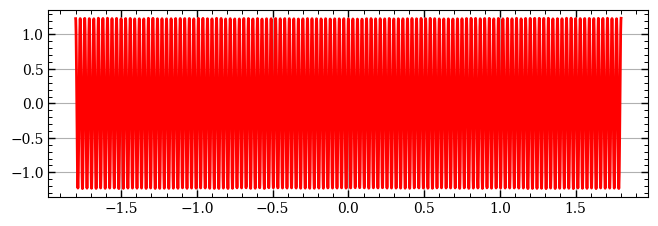

In [153]:
lam_u = 30e-3
Bmax = 1.231
Nu = 120
Lu = Nu*lam_u

rdm = np.random.rand(Nu*2+1)*2.-1.
def fBy_z(z, delB = 0.01):
    loc = int((z+Lu/2.)/(lam_u/2.))
    return Bmax*(1.+delB/Bmax*rdm[loc])*np.cos(2.*np.pi*z/lam_u)


delB = 0.005; Bp = Bmax*(1.+delB/Bmax*rdm)
print 'std_B/B =: ', np.std(Bp)/Bmax*100, ' %'

zz = np.linspace(-Lu/2., Lu/2., Nu*32)
By = np.array([fBy_z(zi, delB) for zi in zz])
fBy_z = interp1d(zz, By, fill_value = 0, bounds_error = False)

fig, ax = plt.subplots(figsize = (8, 2.5))
ax.plot(zz, By, '-')
ax.grid()

Bp = []
for i in np.arange(2*Nu+1):
    select = (zz>=-Lu/2.+i*lam_u*0.5)*(zz<=-Lu/2.+(i+1)*lam_u*0.5)
    index, v = index_max(np.abs(By[select])); zi = zz[select][index]
    Bp.append([zi, v]) 
Bp = np.array(Bp); #print Bp

std_B, mean_B = np.std(Bp[:,1]), np.mean(Bp[:,1])
print 'mean magnetic field: ', mean_B
print 'std_B/B  = : ', std_B/Bmax*100, ' %'

-1.7999999999999998 1.7999999999999998 0.0009375000000000355
I1 =:  3.589906464245701e-05
118.67300886211814
116.32748096724146


(-2, 2)

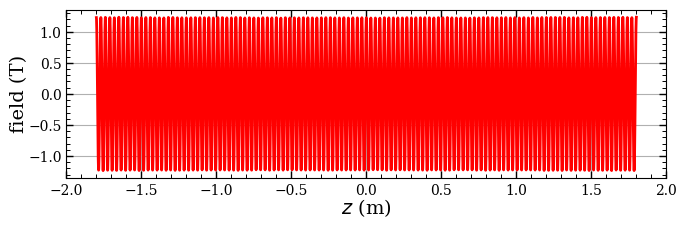

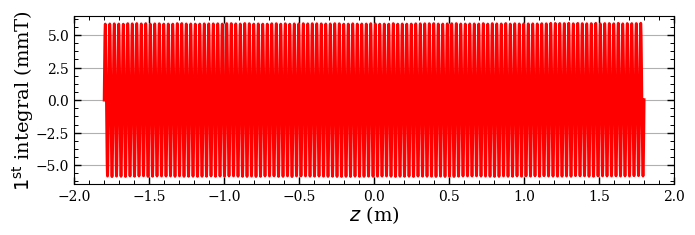

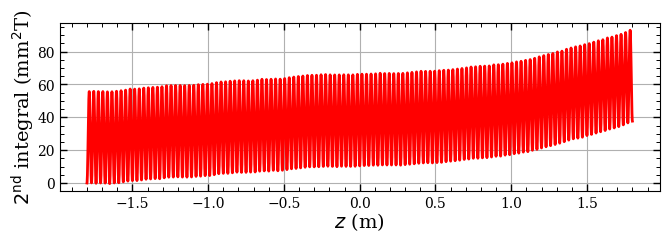

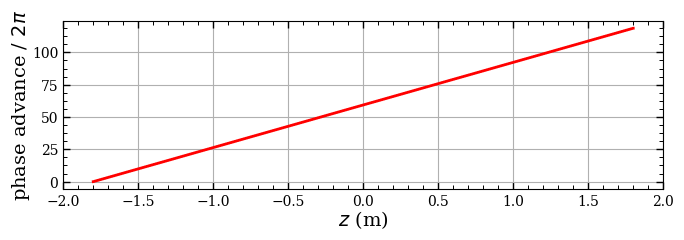

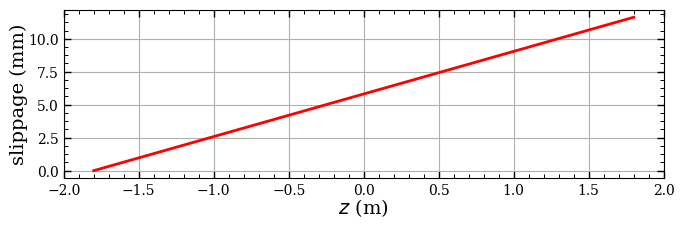

In [154]:
workdir = rootdir+r'\simul\LCLS-1 undulator fields'
os.chdir(workdir)

#Nu = 120; lam_u = 0.03; Lu = Nu*lam_u # meter
Bmax = 1.2309145836874706 #1.236333991102783 #1.2740679 #1.1997472 #1.2799855353434733 # Tesla
Ku = undulator_parameter(Bmax, lam_u) # unitless
gamma_b = kinetic2gamma(momentum2kinetic(16.65))

zz = np.linspace(-Lu/2., Lu/2., Nu*32+1); dz = zz[1]-zz[0]; print zz[0], zz[-1], dz
By = fBy_z(zz)

fI1_z = first_integral_z(fBy_z, Lu, Nz = len(zz))
I1 = np.array([fI1_z(zi) for zi in zz]); print 'I1 =: ', I1[-1]

fI2_z = second_integral_z(fI1_z, Lu, Nz = len(zz))
I2 = np.array([fI2_z(zi) for zi in zz])
    
fPA_z = phase_advance_z(fI1_z, Lu, Ku, lam_u, Nz = len(zz))
PA = np.array([fPA_z(zi) for zi in zz])

fPATH_z = path_advance_z(fI1_z, Lu, gamma_b, Nz = len(zz))
PATH = np.array([fPATH_z(zi) for zi in zz])

xmin, xmax = -1.71/lam_u, -1.41/lam_u
fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, By, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'field (T)')
ax.set_xlim(-2, 2)
#fig.savefig('By-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, I1*1e3, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'$1^{\rm st}$ integral (mmT)')
ax.set_xlim(-2, 2)
#fig.savefig('I1-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, I2*1e6, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'$2^{\rm nd}$ integral (mm$^2$T)')
#fig.savefig('I2-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, PA/2./np.pi, '-'); print PA[-1]/2./np.pi
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'phase advance / $2\pi$')
ax.set_xlim(-2, 2)
#ax.set_ylim(0, 10)
#fig.savefig('PA-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, PATH*1e3, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'slippage (mm)'); print PATH[-1]*1e3/0.1
ax.set_xlim(-2, 2)
#ax.set_ylim(0, 10)
#fig.savefig('PATH-z.eps')

Ku, Keff =:  3.44802192131 3.4256492151188898
resonant wavelength =:  96.93818373480725  um
coef =:  5.368274186532258
rms phase errors =:  2.3223541872060487  degree
rms field errors =:  0.75504204062284  %
rms local phase errors =:  0.018961798327925543  radian
rms local field errors =:  0.3532196320280408  %


(-20, 20)

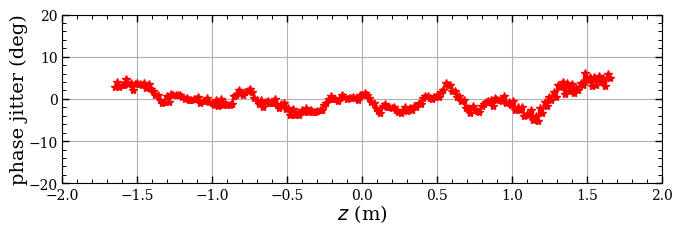

In [155]:
zpol = np.linspace(-Lu/2., Lu/2., 2*Nu+1); #print zpol

PATH1 = np.array([fPATH_z(zi) for zi in zpol])

d = 10

f_z = lambda x, a, b: a+b*x
popt, pcov = curve_fit(f_z, zpol[d:-d], PATH1[d:-d])
a, b = popt

Keff = np.sqrt(2.*(2.*gamma_b**2*b-1))
print 'Ku, Keff =: ', Ku, Keff 

lam_s = resonant_wavelength(Keff, lam_u, gamma_b)
print 'resonant wavelength =: ', lam_s*1e6, ' um'

dPA = (PATH1[d:-d]-f_z(zpol[d:-d], *popt))*2.*np.pi/lam_s # phase errors in radian
std_dPA = np.std(dPA)

coef = np.pi*Keff**2/(1.+0.5*Keff**2); print 'coef =: ', coef

dpsi = np.zeros(len(dPA))
for i in np.arange(1, len(dpsi)):
    dpsi[i] = dPA[i]-dPA[i-1]
std_dpsi = np.std(dpsi)

print 'rms phase errors =: ', std_dPA/np.pi*180, ' degree'
print 'rms field errors =: ', std_dPA/coef*100, ' %'
print 'rms local phase errors =: ', std_dpsi, ' radian'
print 'rms local field errors =: ', std_dpsi/coef*100, ' %'

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zpol[d:-d], dPA/2./np.pi*360, '-*')
#ax.plot(zpol[d:-d]/lam_u*2, dpsi/2./np.pi*360, '-*')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'phase jitter (deg)')
ax.set_xlim(-2, 2)
ax.set_ylim(-20, 20)
#fig.savefig('phase-jetter.eps')

peak magnetic field:  1.2799839
mean magnetic field:  1.274786938
std_K, K = :  0.0074463408615274805 3.5709165895628656
std_K/K  = :  0.20852743755739828  %


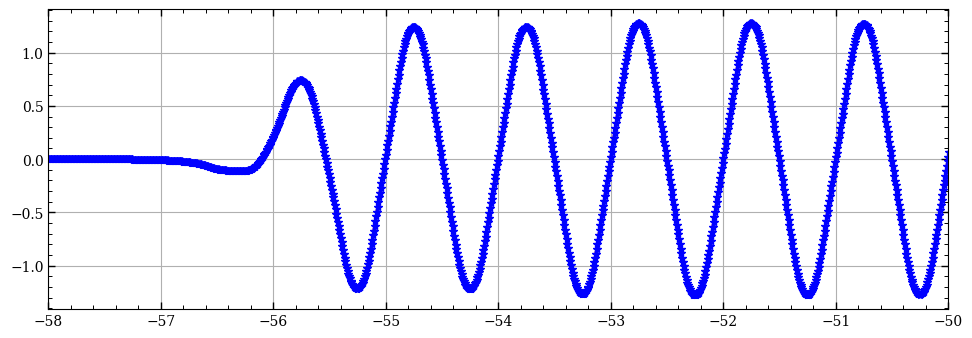

In [36]:
workdir = rootdir+r'\simul\LCLS-1 undulator fields'
os.chdir(workdir)

NumberOfHarmonics = 15
# set the undulator parameters
Nu = 120; lam_u = 0.03; Lu = Nu*lam_u

data = np.loadtxt('slacBySym6.txt')
z = data[:,0]; By = data[:,1]; dz = z[1]-z[0]

# find the rough center
z0 = np.sum(z*np.abs(By))/np.sum(np.abs(By))
z = z-z0

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(z/lam_u, By, '-')
ax.grid()
#ax.set_xlim(-1.8, -1.0)

print 'peak magnetic field: ', np.max(By)

# find exact center where By=0
index, tmp = index_min(np.abs(z))
Nz_quater = int(lam_u/4./dz)
fz_By = interp1d(By[index-Nz_quater:index+Nz_quater], z[index-Nz_quater:index+Nz_quater])
z00 = fz_By(0)
z = z-z00

select = (z<=Lu/2.)*(z>=-Lu/2.)
z = z[select]
By = By[select]

ax.plot(z/lam_u, By, '-*')
ax.set_xlim(-58, -50)
#ax.set_xlim(-0.09, 0.09)

Bmax = []
for i in np.arange(2*Nu):
    select = (z>=-Lu/2.+i*lam_u*0.5)*(z<=-Lu/2.+(i+1)*lam_u*0.5)
    index, v = index_max(np.abs(By[select])); zi = z[select][index]
    Bmax.append([zi, v]) 
Bmax = np.array(Bmax)
np.savetxt('Bmax.dat', Bmax, fmt = '%15.6E')

std_Bmax, mean_Bmax = np.std(Bmax[20:-20,1]), np.mean(Bmax[20:-20,1])
std_K = undulator_parameter(std_Bmax, lam_u)
K = undulator_parameter(mean_Bmax, lam_u)
print 'mean magnetic field: ', mean_Bmax
print 'std_K, K = : ', std_K, K
print 'std_K/K  = : ', std_K/K*100, ' %'

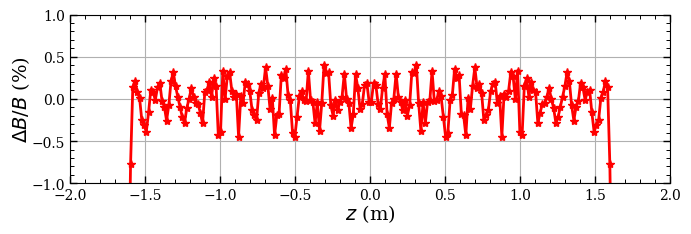

In [47]:
workdir = rootdir+r'\simul\LCLS-1 undulator fields'
os.chdir(workdir)

data = np.loadtxt('Bmax.dat')

d = 20
Bavg = np.mean(data[d:-d,1])

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(data[:,0], (data[:,1]-Bavg)/Bavg*100, '-*')
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)
ax.grid()
ax.set_xlabel(r'$z$ (m)')
ax.set_ylabel(r'$\Delta B/B$ (%)')
fig.savefig('dB-B.eps')

1.199747284994933


Text(0,0.5,'$(a_n^2+b_n^2)^{1/2}$')

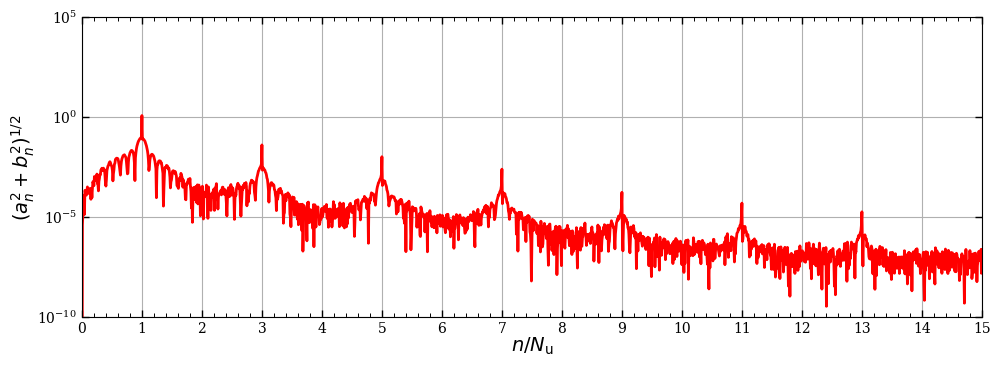

In [110]:
# Fourier analysis
nharm = np.arange(0, Nu*NumberOfHarmonics+1)

k_n = 2.*np.pi*nharm/Lu

xi = 0
ky_n = k_n/np.sqrt(1+xi**2)
kx_n = xi*ky_n

a_0 = np.sum(By*dz)/Lu; #print a_0
#b_0 = 0

a_n = [2./Lu*np.sum(By*np.cos(k_n[i]*z)*dz) for i in nharm]
b_n = [2./Lu*np.sum(By*np.sin(k_n[i]*z)*dz) for i in nharm]
    
a_n = np.array(a_n); a_n[0] = a_n[0]/2.; #print a_n[0]
b_n = np.array(b_n); #print b_n[0]

np.savetxt('spectrum.dat', np.array([nharm, a_n, b_n]).T, fmt = '%15.6E')
print np.sqrt(np.sum((a_n**2+b_n**2)))#*120/113.

spectrum = np.sqrt(a_n**2+b_n**2)

fig, ax = plt.subplots(figsize = (12,4))
ax.plot(1.0*nharm/Nu, spectrum, '-')
ax.set_yscale('log')
ax.set_xlim(0, 15)
ax.set_xticks(np.arange(16))
ax.set_ylim(1e-10, 1e5)
ax.set_yticks([1e-10, 1e-5, 1e0, 1e5])
ax.grid()
ax.set_xlabel(r'$n/N_{\rm u}$')
ax.set_ylabel(r'$(a_n^2+b_n^2)^{1/2}$')

-1.7999999999999998 1.7999999999999998 0.0009375000000000355
I1 =:  -6.485060268213275e-17
114.49072539536674
112.22785877814313


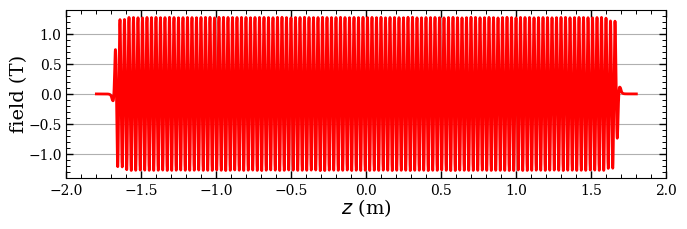

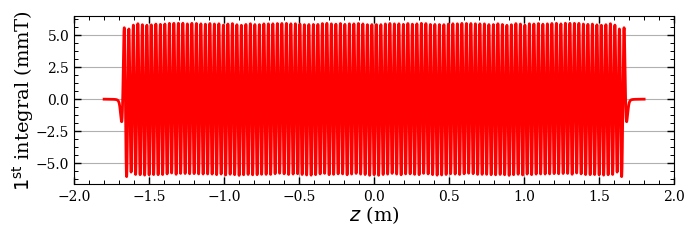

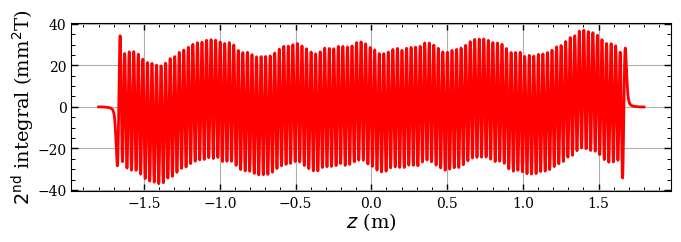

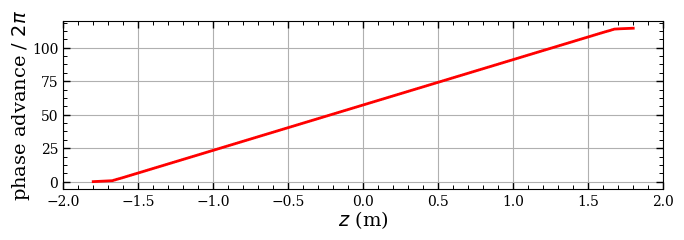

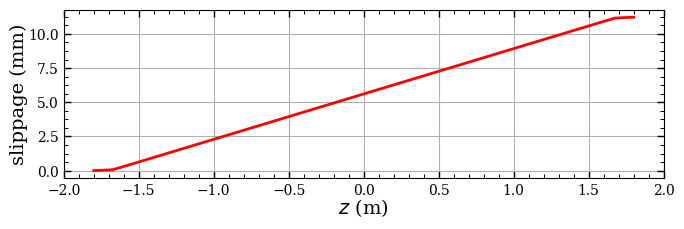

In [48]:
workdir = rootdir+r'\simul\LCLS-1 undulator fields'
os.chdir(workdir)

Nu = 120; lam_u = 0.03; Lu = Nu*lam_u # meter
Bmax = 1.2309145836874706 #1.236333991102783 #1.2740679 #1.1997472 #1.2799855353434733 # Tesla
Ku = undulator_parameter(Bmax, lam_u) # unitless
gamma_b = kinetic2gamma(momentum2kinetic(16.65))

data = np.loadtxt('slacBySym6.txt')
zz = data[:,0]; By = data[:,1]

# find the rough center
z0 = np.sum(zz*np.abs(By))/np.sum(np.abs(By))
zz = zz-z0
# find exact center where By=0
index, tmp = index_min(np.abs(zz))
Nz_quater = int(lam_u/4./dz)
fz_By = interp1d(By[index-Nz_quater:index+Nz_quater], zz[index-Nz_quater:index+Nz_quater])
z00 = fz_By(0)
zz = zz-z00

#select = (zz<=Lu/2.+0.1e-9)*(zz>=-Lu/2.-0.1e-9)
#zz = zz[select]; dz = zz[1]-zz[0]; print zz[0], zz[-1], Lu/2.
#By = By[select]

fBy_z = interp1d(zz, By, bounds_error = None, fill_value = "extrapolate")

zz = np.linspace(-Lu/2., Lu/2., Nu*32+1); dz = zz[1]-zz[0]; print zz[0], zz[-1], dz
By = fBy_z(zz)

#fI1_z = first_integral_z(fBy_z, Lu, Nz = len(zz))
I1 = np.array([fI1_z(zi) for zi in zz]); print 'I1 =: ', I1[-1]

#fI2_z = second_integral_z(fI1_z, Lu, Nz = len(zz))
I2 = np.array([fI2_z(zi) for zi in zz])
    
#fPA_z = phase_advance_z(fI1_z, Lu, Ku, lam_u, Nz = len(zz))
PA = np.array([fPA_z(zi) for zi in zz])

#fPATH_z = path_advance_z(fI1_z, Lu, gamma_b, Nz = len(zz))
PATH = np.array([fPATH_z(zi) for zi in zz])

xmin, xmax = -1.71/lam_u, -1.41/lam_u
fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, By, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'field (T)')
ax.set_xlim(-2, 2)
fig.savefig('By-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, I1*1e3, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'$1^{\rm st}$ integral (mmT)')
ax.set_xlim(-2, 2)
fig.savefig('I1-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, I2*1e6, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'$2^{\rm nd}$ integral (mm$^2$T)')
fig.savefig('I2-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, PA/2./np.pi, '-'); print PA[-1]/2./np.pi
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'phase advance / $2\pi$')
ax.set_xlim(-2, 2)
#ax.set_ylim(0, 10)
fig.savefig('PA-z.eps')

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zz, PATH*1e3, '-')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'slippage (mm)'); print PATH[-1]*1e3/0.1
ax.set_xlim(-2, 2)
#ax.set_ylim(0, 10)
fig.savefig('PATH-z.eps')

Ku, Keff =:  3.44802192131 3.479425706844834
resonant wavelength =:  99.55892883332992  um
coef =:  5.392357901203741
rms phase errors =:  1.804094639410514  degree
rms field errors =:  0.5839262165492459  %
rms local phase errors =:  0.04660149181436538  radian
rms local field errors =:  0.8642136272883981  %


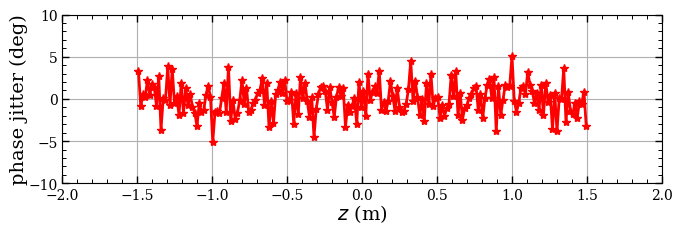

In [49]:
zpol = np.linspace(-Lu/2.+0.25*lam_u, Lu/2.-0.25*lam_u, 2*Nu); #print zpol

PATH1 = np.array([fPATH_z(zi) for zi in zpol])

d = 20

f_z = lambda x, a, b: a+b*x
popt, pcov = curve_fit(f_z, zpol[d:-d], PATH1[d:-d])
a, b = popt

Keff = np.sqrt(2.*(2.*gamma_b**2*b-1))
print 'Ku, Keff =: ', Ku, Keff 

lam_s = resonant_wavelength(Keff, lam_u, gamma_b)
print 'resonant wavelength =: ', lam_s*1e6, ' um'

dPA = (PATH1[d:-d]-f_z(zpol[d:-d], *popt))*2.*np.pi/lam_s # phase errors in radian
std_dPA = np.std(dPA)

coef = np.pi*Keff**2/(1.+0.5*Keff**2); print 'coef =: ', coef

dpsi = np.zeros(len(dPA))
for i in np.arange(1, len(dpsi)):
    dpsi[i] = dPA[i]-dPA[i-1]
std_dpsi = np.std(dpsi)

print 'rms phase errors =: ', std_dPA/np.pi*180, ' degree'
print 'rms field errors =: ', std_dPA/coef*100, ' %'
print 'rms local phase errors =: ', std_dpsi, ' radian'
print 'rms local field errors =: ', std_dpsi/coef*100, ' %'

fig, ax = plt.subplots(figsize = (8, 2.25))
ax.plot(zpol[d:-d], dPA/2./np.pi*360, '-*')
#ax.plot(zpol[d:-d]/lam_u*2, dpsi/2./np.pi*360, '-*')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'phase jitter (deg)')
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
fig.savefig('phase-jetter.eps')

3.420314792862693


(-10, 10)

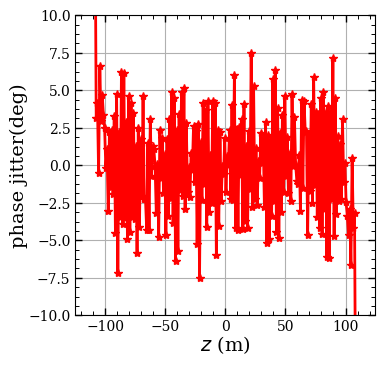

In [66]:
zpol = np.linspace(-Lu/2.+0.25*lam_u, Lu/2.-0.25*lam_u, 2*Nu); #print zpol

PA0 = np.array([i*2.*np.pi for i in np.arange(len(zpol))])
PA1 = np.array([fPA_z(zi) for zi in zpol])
dphi = PA0-PA1
np.savetxt('phase_jitter.dat', np.array([zpol/lam_u*2, PA0, PA1]).T, fmt = '%15.6E')

d = 10

f_z = lambda x, a, b: a+b*x
popt, pcov = curve_fit(f_z, zpol[d:-d], PA1[d:-d])
a, b = popt

print np.std((PA1[d:-d]-f_z(zpol[d:-d], *popt))/np.pi*180)

fig, ax = plt.subplots()
#ax.plot(zpol/lam_u*2, PA1/2./np.pi*360, '-')
#ax.plot(zpol/lam_u*2, f_z(zpol, *popt)/2./np.pi*360, '-')
ax.plot(zpol/lam_u*2, (PA1-f_z(zpol, *popt))/2./np.pi*360, '-*')
ax.grid()
ax.set_xlabel(u_z)
ax.set_ylabel(r'phase jitter(deg)')
#ax.set_xlim(-Nu+d, Nu-d)
ax.set_ylim(-10, 10)

# Space charge calculation between `Astra` and `GPT`
## `Astra` to `GPT`

In [15]:
def astra2gpt(fname):
    '''
    Convert Astra time snapshot distribution into gpt input beam distributions
    Parameter
      fname: the Astra output in ascii format or initial distribution in spatial domain longitudinally.
    Return
      write the beam distribution for GPT input in the ascii format
    '''
    beam = np.loadtxt(fname)
    beam[1:,2] += beam[0,2]
    beam[1:,5] += beam[0,5]
    
    beam[:,3:6] = beam[:,3:6]/g_mec2/1e6 # to beta*gamma: GBx GBy GBz
    beam[:,6] = -beam[:,7]*1e-9/g_qe # number of macro particles: nmacro
    beam[:,7] = -g_qe # q
    
    np.savetxt('beam_und.ini', beam[:,0:8], fmt = '%15.6E',\
               header = 'x  y  z  GBx  GBy  GBz nmacro q', comments='')
    return

def gpt_split(fname, flag = 'time        '):
    '''
    Split GPT output by time
    Parameter
      fname: the GPT output in ascii format
    Return
      write the time series into disk with the name format of `time_0.00ns.txt` 
    '''
    L_title, L_write = False, False
    with open(fname, 'rU') as f:
        for line in f:
            if flag in line:
                a = line.split()
                time = float(a[1])*1e9; print time,
                if 1:#np.abs(time-6.6)<1e-3:
                    fout = open(str.format('time-%.2fns.txt' % time), "w")
                    fout.write('# '+line)
                    L_title, L_write = True, True
                continue
            if L_write and line.isspace():
                fout.close()
                L_write = False
                continue
            if L_title:
                fout.write('# '+line)
                L_title = False
                continue
            if L_write:
                fout.write(line)
    return

def transform_velocity(u, v):
    '''
    Parameters
      u = [ux, uy, uz]/c: velocity of an object in the lab frame
      v = [vx, vy, vz]/c: velocity of the moving frame in the lab frame
    Return
      u_prime = [ux_prime, uy_prime, uz_prime]/c: velocity of the object in the rest frame
    '''
    u = np.asarray(u)
    v = np.asarray(v)
    gamma_v = 1./np.sqrt(1.-np.sum(v*v))
    return 1./(1.-np.sum(v*u))*(u/gamma_v-v+gamma_v/(gamma_v+1.)*np.sum(u*v)*v)

#workdir = rootdir + r'/simul/test-undulator-6/n200k-sig_x-1.55mm-sig_y-0.34mm-alp_x-7.36-alp_y-4.43/GPT'
#os.chdir(workdir)

#fname = 'beam_und.ini'
#astra2gpt(fname)

#os.system('asci2gdf -o beam_und.gdf beam_und.ini')

## SC models compensation

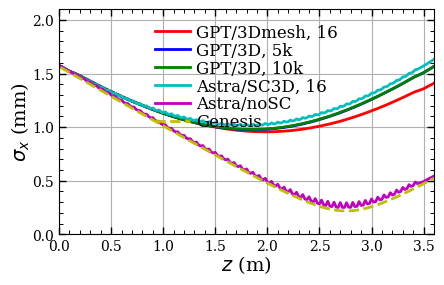

In [161]:
workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.58mm-sig_y-0.18mm-alp_x-7.18-alp_y-1.72/GPT'
#workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.55mm-sig_y-0.34mm-alp_x-7.36-alp_y-4.43/GPT'
os.chdir(workdir)

fig, ax = plt.subplots(figsize = (5, 3))

#data = np.loadtxt('3Dmesh/std.txt', skiprows = 1)
#ax.plot(data[:,1], data[:,4]*1e3, '-')

data = np.loadtxt('3Dmesh-16/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,4]*1e3, '-')

data = np.loadtxt('3D5k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,4]*1e3, '-')

data = np.loadtxt('3D10k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,4]*1e3, '-')

ax.grid()

ax.set_xlim(0, 3.6)
ax.set_ylim(0., 2.1)

data = np.loadtxt('../ast.Xemit.001')
ax.plot(data[:,0], data[:,3], '-')
data = np.loadtxt('../ast.Xemit.003')
ax.plot(data[:,0], data[:,3], '-')

data = np.loadtxt('../Genesis/xy_rms-z.dat')
ax.plot(data[:,0], data[:,1], '--')

ax.legend(['GPT/3Dmesh, 16', 'GPT/3D, 5k', 'GPT/3D, 10k', 'Astra/SC3D, 16', 'Astra/noSC', 'Genesis'],\
          loc = 'upper center')

ax.set_xlabel(u_z)
ax.set_ylabel(u_rms_x)

fig.savefig('rms_x-z.3.eps')

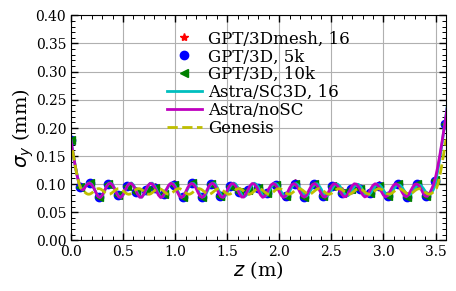

In [162]:
fig, ax = plt.subplots(figsize=(5, 3))

data = np.loadtxt('3Dmesh-16/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,5]*1e3, '*')

data = np.loadtxt('3D5k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,5]*1e3, 'o')

data = np.loadtxt('3D10k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,5]*1e3, '<')

ax.grid()

ax.set_xlim(0, 3.6)
ax.set_ylim(0.0, 0.4)
#ax.set_yticks([0.05, 0.10, 0.15, 0.20, 0.25])

data = np.loadtxt('../ast.Yemit.001')
ax.plot(data[:,0], data[:,3], '-')

data = np.loadtxt('../ast.Yemit.003')
ax.plot(data[:,0], data[:,3], '-')

data = np.loadtxt('../Genesis/xy_rms-z.dat')
ax.plot(data[:,0], data[:,2], '--')

ax.legend(['GPT/3Dmesh, 16', 'GPT/3D, 5k', 'GPT/3D, 10k', 'Astra/SC3D, 16', 'Astra/noSC', 'Genesis'],\
          loc = 'upper center')

ax.set_xlabel(u_z)
ax.set_ylabel(u_rms_y)

fig.savefig('rms_y-z.3.eps')

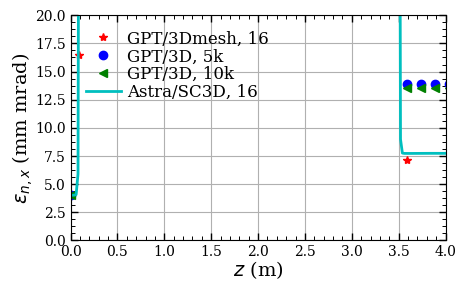

In [5]:
fig, ax = plt.subplots(figsize = (5, 3))

data = np.loadtxt('3Dmesh-16/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,2]*1e6, '*')

data = np.loadtxt('3D5k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,2]*1e6, 'o')

data = np.loadtxt('3D10k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,2]*1e6, '<')
ax.grid()

ax.set_xlim(0, 4)
ax.set_ylim(0, 20)

data = np.loadtxt('../ast.Xemit.001')
ax.plot(data[:,0], data[:,5], '-')

ax.legend(['GPT/3Dmesh, 16', 'GPT/3D, 5k', 'GPT/3D, 10k', 'Astra/SC3D, 16'], loc = 'upper left')

ax.set_xlabel(u_z)
ax.set_ylabel(u_emi_x)

fig.savefig('emi_x-z.eps')

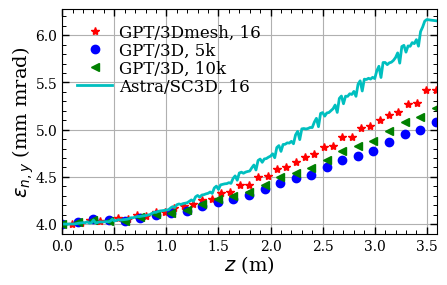

In [6]:
fig, ax = plt.subplots(figsize = (5, 3))

data = np.loadtxt('3Dmesh-16/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,3]*1e6, '*')

data = np.loadtxt('3D5k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,3]*1e6, 'o')

data = np.loadtxt('3D10k/std.txt', skiprows = 1)
ax.plot(data[:,1], data[:,3]*1e6, '<')
ax.grid()

ax.set_xlim(0, 3.6)

data = np.loadtxt('../ast.Yemit.001')
ax.plot(data[:,0], data[:,5], '-')

ax.legend(['GPT/3Dmesh, 16', 'GPT/3D, 5k', 'GPT/3D, 10k', 'Astra/SC3D, 16'])

ax.set_xlabel(u_z)
ax.set_ylabel(u_emi_y)

fig.savefig('emi_y-z.eps')

## Long. beam distribution in the rest frame

In [ ]:
gpt_split('result.txt')  

In [ ]:
for time in np.linspace(0, 9.6, 33):
    fname = str.format('time-%.2fns.txt' % time)
    data = np.loadtxt(fname)

    fig, ax = plt.subplots()
    ax.plot(data[:,2], data[:,3], '.')
    ax.plot(data[:,2], data[:,4], '.')
    ax.grid()

    fig.savefig('beta_x-z@'+str.format('%.2fns' % time)+'.png')

[-1.26579309e-02 -7.59689007e-07  9.98609939e-01]
52182


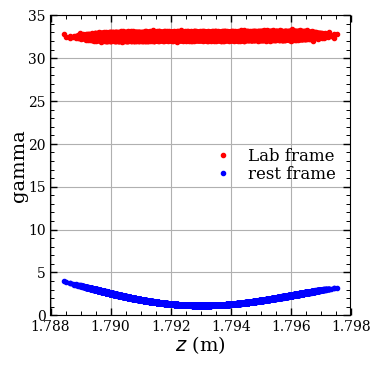

In [157]:
time = 6
fname = str.format('time-%.2fns.txt' % time)
data = np.loadtxt(fname)

fig, ax = plt.subplots()
ax.plot(data[:,2], data[:,6], '.')

beta_x = weighted_mean(data[:,3], data[:,6])
beta_y = weighted_mean(data[:,4], data[:,6])
beta_z = weighted_mean(data[:,5], data[:,6])

v = np.asarray([beta_x, beta_y, beta_z]); print v

for i in np.arange(len(data)):
    u = data[i,3:6]
    up = transform_velocity(u, v)
    data[i,3:6] = up
    data[i,6] = beta2gamma(np.sqrt(up[0]**2+up[1]**2+up[2]**2))


ax.plot(data[:,2], data[:,6], '.')
ax.grid()

ax.set_xlabel(u_z)
ax.set_ylabel(r'gamma')

ax.set_ylim(0, 35)

ax.legend(['Lab frame', 'rest frame'], loc = 'center right')
fig.savefig('gamma-z.png')

print len(data[data[:,6]>2])

# `Genesis 1.3` simulation

In [253]:
def _write_(ss, filename):
    '''
    Write the string <ss> into a file
    '''
    ff = open(filename, 'w')
    ff.write(ss)
    ff.close()
    return

class Genesis:
    def __init__(self, **kwargs):
        self.name = 'newrun'
        
        undulator = {'aw0':1.0, 'xlamd':3.0e-2, 'nwig':120, 'nsec':1, 'xkx':0, 'xky':1, 'iwityp':0, 'awd':1.0}
        electron  = {'npart':8192, 'gamma0':20, 'delgam':0.5e-2, 'rxbeam':1e-3, 'rybeam':1e-3, 'emitx':2e-6,\
                     'emity':2e-6, 'alphax':0, 'alphay':0, 'curpeak':1e2, 'bunch':0}
        radiation = {'xlamds':100e-6, 'prad0':0, 'zrayl':0.1, 'zwaist':0}
        grid      = {'ncar':201,'rmax0':9, 'dgrid':0, 'nscz':1, 'nscr':1, 'nptr':40}
        control   = {'delz':1, 'zstop':0, 'nbins':4, 'iall':0, 'ipseed':-1, 'shotnoise':1}
        time      = {'itdp':0, 'curlen':1e-3, 'zsep':1, 'nslice':408, 'ntail':-253, 'iotail':0}
        io        = {'iphsty':1, 'ishsty':1, 'ippart':0, 'ispart':0, 'ipradi':0, 'isradi':0, 'idump':0, 'idmpfld':0,\
                     'idmppar':0, 'ffspec':0}
        lout      = {'lout':[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]}
        focusing  = {'quadf':0}
        
        modules = [undulator, electron, radiation, grid, control, time, io, lout, focusing]
        self.kv = {}
        
        for module in modules:
            self.kv.update(module)
        
        for k, v in kwargs.items():
            self.kv.update({k:v})
        self.build()
    def set(self,**kwargs):
        for k, v in kwargs.items():
            self.kv.update({k:v})
        self.build()
    def build(self):
        output = ' $'+self.name.upper()+' \n'
        for k, v in self.kv.items():
            if isinstance(v, int) and not isinstance(v, bool):
                output += str.format(' %-9s = %d\n' % (k.upper(), v))
            elif isinstance(v, float):
                output += str.format(' %-9s = %f\n' % (k.upper(), v))
            elif isinstance(v, str):
                output += str.format(' %-9s = \'%s\'\n' % (k.upper(), v))
            elif isinstance(v, bool):
                output += str.format(' %-9s = %s\n' % (k.upper(), str(v))) 
            elif isinstance(v, (list, np.ndarray)):
                output += str.format(' %-9s = ' % k.upper())
                for v1 in v:
                    output += str.format('%s ' % (str(v1)))
                output += '\n'
        output += ' $END\n'
        self.output = output
    
    def readdata(self, fname):
        data=open(fname, 'r')
        line=data.readline()

        kv = {}

        while True:
            if not line:
                break

            match = re.search(r'^[^=]*=[^=]*$' , line)
            if match:
                # print line
                key, value = line.split('=')
                match = re.search(r'file', key)
                if match:
                    kv.update({key.strip():value})
                    line=data.readline()
                    continue

                if len(value.split()) == 1:
                    value = np.float(value.replace("D", "E"))
                else:
                    value = [np.float(v.replace("D", "E")) for v in value.split()]
                kv.update({key.strip():value})          

            match = re.search(r'^[ ]*z\[m\][ ]*aw[ ]*qfld[ ]*$', line)
            if match:
                # print line
                nz = np.int(kv['zstop']/kv['delz']/kv['xlamd'])+1
                field = np.zeros((nz, 3))
                for i in np.arange(nz):
                    line = data.readline()
                    field[i] = np.array([np.float(v.replace("D", "E")) for v in line.split()])
                break
            line=data.readline()

        nt = np.int(kv['nslice'])
        nc = np.int(np.sum(kv['lout'])); #print nc

        current = np.zeros((nt, 2))
        results = np.zeros((nt, nz, nc)); #print results.shape

        islice = 0
        while True:
            if not line:
                break
            match = re.search(r'[ E]* current', line)
            if match:
                icurrent, tmp = line.split()
                icurrent = np.float(icurrent)
                current[islice, 0] = islice+1; current[islice, 1] = icurrent


                line = data.readline()
                line = data.readline()
                line = data.readline()

                outputs = line.split()

                for j in np.arange(nz):
                    line = data.readline(); #print line
                    results[islice, j] = np.array([np.float(v.replace("D", "E")) for v in line.split()])
                #break
                islice += 1
            line = data.readline()
        self.kv = kv
        self.nt = nt; self.nz = nz; self.nc = nc
        self.field = field
        self.current = current
        self.data = results
        return
    def get_power_at(self, z = None):
        '''
        Get the radiation power distribution at position i, with i refering to the ith time step
        Parameters
          fname: the name of the file where stores the standard output of genesis
        Returns
          a 2D array that stores the radition temporal distribution at position i
        '''
    
        if z == None:
            z = self.kv['zstop']
        col = np.int(z/self.kv['delz']/self.kv['xlamd'])
        
        nt = self.nt
        dist = np.zeros((nt, 2))
        
        period_s = self.kv['xlamds']/g_c
        dist[:,0] = np.arange(nt)*period_s*g_c # meter
        dist[:,1] = self.data[:, col, 0]
        
        return dist
    
    def get_spectrum_at(self, z = None):
        if z == None:
            z = self.kv['zstop']
        col = np.int(z/self.kv['delz']/self.kv['xlamd'])
        
        nt = self.nt
        dist = np.zeros((nt, 2))
        
        amp = self.data[:, col, 2]
        phase = self.data[:, col, 3]
        
        signal = np.zeros(nt, dtype = complex)
        
        for i in np.arange(nt):
            signal[i] = np.sqrt(amp[i])*np.complex(np.cos(phase[i]), np.sin(phase[i]))

        spectrum = np.abs(fftshift(fft(signal, nt)))
        spectrum = spectrum*spectrum

        period_s = self.kv['xlamds']/g_c
        freq_s = 1./period_s
        F = 1.0*np.arange(-nt/2, nt/2,)/nt*freq_s+freq_s # Frequency
        F = g_c/F # Frequency to wavelength

        dist[:,0] = F; dist[:,1] = spectrum
        return dist

    def get_power(self):
        
        nz = self.nz; print nz
        dist = np.zeros((nz, 2))
        dist[:,0] = self.field[:,0]
        
        dist[:,1] = self.data[:,:,0].sum(axis=0)
        return dist

    def get_energy(self):
        
        nz = self.nz
        dist = np.zeros((nz, 2))
        dist[:,0] = self.field[:,0]
        
        period_s = self.kv['xlamds']/g_c
        dist[:,1] = self.data[:,:,0].sum(axis=0)*period_s
        return dist

    def get_rms_x(self):
        
        nz = self.nz
        dist = np.zeros((nz, 2))
        dist[:,0] = self.field[:,0]
        
        period_s = self.kv['xlamds']/g_c
        
        xrms = self.data[:,:,7]
        current = self.current
        
        for i in np.arange(xrms.shape[1]):
            dist[i, 1] = np.sqrt(np.sum(xrms[:,i]*xrms[:,i]*current[:,1])/np.sum(current[:,1]))
    
        return dist
    
    def get_rms_y(self):
        
        nz = self.nz
        dist = np.zeros((nz, 2))
        dist[:,0] = self.field[:,0]
        
        period_s = self.kv['xlamds']/g_c
        
        xrms = self.data[:,:,8]
        current = self.current
        
        for i in np.arange(xrms.shape[1]):
            dist[i, 1] = np.sqrt(np.sum(xrms[:,i]*xrms[:,i]*current[:,1])/np.sum(current[:,1]))
    
        return dist
    
    def write(self, filename = 'fel', suffix = None):
        if suffix is None:
            suffix = '.in'
        ff = open(filename+suffix, 'w')
        ff.write(self.output)
        ff.close()
        return
    
    def qsub(self, filename):
        con = '''\
#!/bin/zsh
#
#$ -cwd
#$ -o '''+filename+'''.o
#$ -e '''+filename+'''.e
#$ -V
#$ -l h_cpu=12:00:00
#$ -l h_rss=2G
#$ -P pitz
##$ -pe multicore 32
##$ -R y
echo '''+fname+'''.in | genesis'''
        _write_(con, fname+'.sh')
        return
#gen = Genesis()
#gen.write()

227


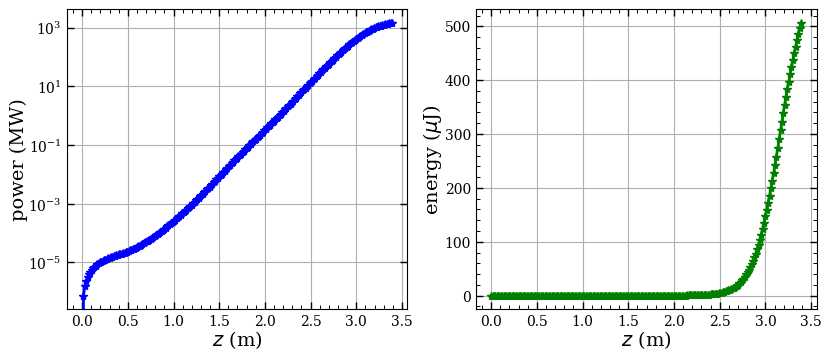

In [264]:
gen = Genesis()
gen.readdata('nominal/pithz.1.out')

tspec = gen.get_power_at()
fspec = gen.get_spectrum_at()
power = gen.get_power()
energy = gen.get_energy()

fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axes[0].plot(tspec[:,0], tspec[:,1], 'r*-')
axes[0].set_xlabel(r'slice ($\mu$m)')
axes[0].set_ylabel(r'power (MW)')

ax1.plot(power[:,0], power[:,1]/1e6, 'b*-') # energy: MW
ax1.set_xlabel(r'$z$ (m)')
ax1.set_ylabel(r'power (MW)')
ax1.set_yscale('log')

ax2.plot(energy[:,0], energy[:,1]*1e6, 'g*-') # energy: uJ
ax2.set_xlabel(r'$z$ (m)')
ax2.set_ylabel(r'energy ($\mu$J)')

ax1.grid()
ax2.grid()

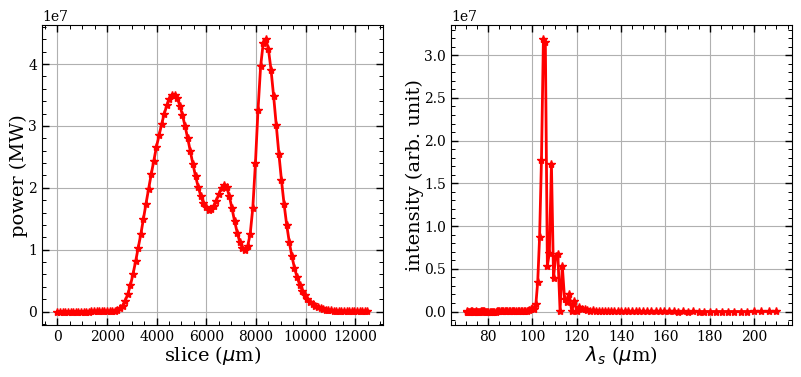

In [266]:
fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax1.plot(tspec[:,0]*1e6, tspec[:,1], 'r*-')
ax1.set_xlabel(r'slice ($\mu$m)')
ax1.set_ylabel(r'power (MW)')

ax2.plot(fspec[:,0]*1e6, fspec[:,1], 'r*-')
ax2.set_xlabel(r'$\lambda_s$ ($\mu$m)')
ax2.set_ylabel(r'intensity (arb. unit)')

ax1.grid()
ax2.grid()

## `Astra` to `Genesis 1.3`

In [16]:
def astra2gen(infile = 'astra.beam', outfile = 'gen.beam', dist = 'p'):
    data = np.loadtxt(infile)
    data[1:,2] += data[0,2]
    data[1:,5] += data[0,5]
    
    data[:,5] = np.sqrt(data[:,3]**2+data[:,4]**2+data[:,5]**2)/g_mec2/1e6 # Pz - > P/mc
    data[:,3] = data[:,3]/g_mec2/1e6 # Px -> Px/mc
    data[:,4] = data[:,4]/g_mec2/1e6 # Py -> Py/mc
    
    tmp = np.copy(data[:,2]) # z -> tmp

    data[:,2] = np.copy(data[:,1])
    data[:,1] = np.copy(data[:,3])
    data[:,3] = np.copy(data[:,4])
    
    if dist == 'p':
        tmp = tmp-np.mean(tmp)+2*np.std(tmp)
        data[:,4] = tmp # tmp -> z
    elif dist == 'g':
        tmp = tmp-np.mean(tmp)
        data[:,4] = tmp

    charge = np.abs(np.sum(data[:,7])*1e-9)
    size = len(data[:,0])
    title = '# Input Distribution for SR-UR\n? VERSION = 1.0\n? CHARGE = '\
            +`charge`+'\n? SIZE = '+`size`+'\n? COLUMNS X PX Y PY Z P'

    np.savetxt(outfile, data[:,0:6], fmt = '%12.4E', header = title, comments = '')

workdir = rootdir+r'\simul\EMSY1toWall\n50k-D-3.50mm-E1-60.00MV_m-phi1--3.89deg-E2-13.41MV_m-phi2--23.06deg-I-360.40A\und'
workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.55mm-sig_y-0.34mm-alp_x-7.36-alp_y-4.43'
workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.58mm-sig_y-0.18mm-alp_x-7.18-alp_y-1.72'
os.chdir(workdir)

#demo_beam('../ast.2700.003')
astra2gen('beam_und.ini', 'pithz.beam.in')

In [ ]:
# check the beam distribution
data = np.loadtxt('beam_und.ini')
data[1:,2] += data[0,2]
data[1:,5] += data[0,5]
print [np.std(data[:,i]) for i in [0, 1, 2]]
print [np.mean(data[:,i])/g_mec2/1e6 for i in [3, 4, 5]]

fig, ax = plt.subplots()
res = ax.hist(data[:,1]*1e3, bins = 50, histtype = u'step')

data = np.loadtxt('pithz.beam', skiprows = 5)
print [np.std(data[:,i]) for i in [0, 2, 4]]
print [np.mean(data[:,i]) for i in [1, 3, 5]]

fig, ax = plt.subplots()
res = ax.hist(data[:,2]*1e3, bins = 50, histtype = u'step')

## Produce `Genesis 1.3` input

In [260]:
Nu, lam_u, B = 120, 3.0e-2, 1.2799839
lam_s = 100e-6
K = undulator_parameter(B,lam_u); print 'undulator parameter: ', K/np.sqrt(2)

Q = 4000e-12 # Coulumm

FWHM = 20.3e-12 # second
sigma_z = FWHM*g_c
curpeak = -Q/FWHM; print 'peak current: ', curpeak

P0 = 16.65 # MeV/c
Ek = momentum2kinetic(P0) # MeV
gamma = kinetic2gamma(Ek); # unitless
delgam = gamma*0.5e-2

Ek, delgam = 1.666378E+01, 9.459161E+01*1e-3

lam_s = 100e-6
lam_s=resonant_wavelength(K, lam_u, gamma)
freq_s = g_c/lam_s
#print 'resonant wavelength from kinetic energy: ', lam_s*1e6, ' um'

gamma1 = resonant_energy(K,lam_u,lam_s)
delgam = gamma*0.5e-2
#print 'resonant momentum from radiation wavelength: ', kinetic2momentum(gamma1*g_mec2-g_mec2)

nslice = Nu+sigma_z/lam_s; print '# of slice: ', nslice
nslice = 125
ntail = 0

emit_x, emit_y = 4e-6, 4e-6
sigma_x, sigma_y = 1.58e-3, 0.18e-3
alpha_x, alpha_y = 7.18, 1.72

delz = 0.5
ipseed = 1
fname = 'pithz.'+`ipseed`

undulator parameter:  2.5353131573026384
peak current:  -197.044334975
# of slice:  178.04460688117973


In [261]:
workdir = simdir + r'/MK-LCLS-I'
#workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.55mm-sig_y-0.34mm-alp_x-7.36-alp_y-4.43/Genesis'
#workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.58mm-sig_y-0.18mm-alp_x-7.18-alp_y-1.72/Genesis'
os.chdir(workdir)

gen=Genesis()

# set the undulator
gen.set(aw0   = K/np.sqrt(2.),\
        awd   = K/np.sqrt(2.),\
        nwig  = Nu,\
        xlamd = lam_u)

# set the electron beam
gen.set(gamma0  = gamma,\
        delgam  = delgam,\
        curpeak = curpeak,\
        rxbeam  = sigma_x,\
        rybeam  = sigma_y,\
        emitx   = emit_x,\
        emity   = emit_y,\
        alphax  = alpha_x,\
        alphay  = alpha_y,\
        npart   = 16384)

# set the grids
gen.set(nslice = nslice,\
        ntail  = ntail,\
        iotail = 1,\
        curlen = sigma_z,\
        itdp   = 1,\
        nbins  = 16)

# set the radiation and control
gen.set(ffspec = 1, ippart = 0, ipradi = 0)
gen.set(xlamds = lam_s, zrayl = 3.5251E-02)
gen.set(nptr = 170, dgrid = 0.01, nscr = 2)
gen.set(delz = delz, zstop = Nu*lam_u)

# gen.set(ipseed = ipseed, delaw = 0.0/np.sqrt(2.), iertyp = 1)
# gen.set(distfile = 'pithz.beam.in', outputfile = fname+'.out')

# gen.write(fname)
# gen.qsub(fname)

In [262]:
cmd = ''; cmd2 = ''
rdm = np.random.rand(100)
samples = []
for ipseed in np.arange(1, 101):
    iseed = np.random.randint(5000, 10000)
    fname = 'pithz.'+`ipseed`

    rr = rdm[ipseed-1]
    Kerr = 0 # K/np.sqrt(2.)*(0.01+0.01*rr)
    samples.append([ipseed, 0.01+0.01*rr])
    gen.set(ipseed = ipseed, delaw = Kerr, iertyp = 0)
    gen.set(beamfile = 'mon132_1det.beam', outputfile = fname+'.out')

    gen.write(fname)
    gen.qsub(fname)
    
    cmd += 'qsub '+fname+'.sh\n'
    
    cmd2 += 'head -n 405 '+fname+'.out | tail -n 227 > '+fname+'.txt\n'
_write_(cmd, 'sub.sh')
_write_(cmd2, 'fld.sh')

Text(0,0.5,'$\\Delta K/K$ (%)')

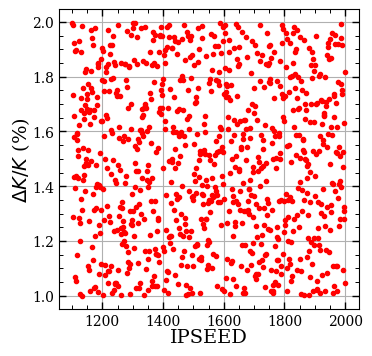

In [239]:
samples = np.array(samples); samples[:,1]
np.savetxt('samples1101-2000.txt', samples, fmt = '%15d%15.6E')

fig, ax = plt.subplots()
ax.plot(samples[:,0], samples[:,1]*100, '.')
ax.grid()
ax.set_xlabel(r'IPSEED')
ax.set_ylabel(r'$\Delta K/K$ (%)')

Text(0,0.5,'$\\Delta K$ (%)')

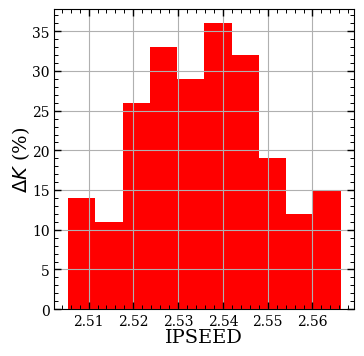

In [225]:
data = np.loadtxt('pithz.100.txt')

fig, ax = plt.subplots()
#ax.plot(data[:,0], data[:,1], '-.')
ax.hist(data[::1,1], bins = 10)
ax.grid()
ax.set_xlabel(r'IPSEED')
ax.set_ylabel(r'$\Delta K$ (%)')

## Radiation power

In [54]:
workdir = simdir + r'/MK-LCLS-I'
workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.55mm-sig_y-0.34mm-alp_x-7.36-alp_y-4.43/Genesis'
workdir = simdir + r'/test-undulator-6/n200k-sig_x-1.58mm-sig_y-0.18mm-alp_x-7.18-alp_y-1.72/Genesis'
os.chdir(workdir)

iseed = 2
slice_dir = 'slices.'+`iseed`
gen_split('pithz.'+`iseed`+'.out', slice_dir)

#slice_dir = 'LCLS-1'
#gen_split('LCLS-1.in.out', slice_dir)

In [55]:
Nu = 113; delz = 0.05

data = gen_sum(0, slice_dir)
power = np.array(data); print len(power)
np.savetxt('power.txt', power, fmt='%12.4E')

data = gen_sum(2, slice_dir)
amp = np.array(data)
np.savetxt('amp.txt', amp, fmt = '%12.4E')

data = gen_sum(3, slice_dir)
phase = np.array(data)
np.savetxt('phase.txt', phase, fmt='%12.4E')

data = gen_sum(6, slice_dir)
phase = np.array(data)
np.savetxt('bunching.txt', phase, fmt='%12.4E')

data = gen_sum(7, slice_dir)
phase = np.array(data)
np.savetxt('xrms.txt', phase, fmt='%12.4E')

data = gen_sum(8, slice_dir)
phase = np.array(data)
np.savetxt('yrms.txt', phase, fmt='%12.4E')

120


(240L, 3L)
74.41708862266789


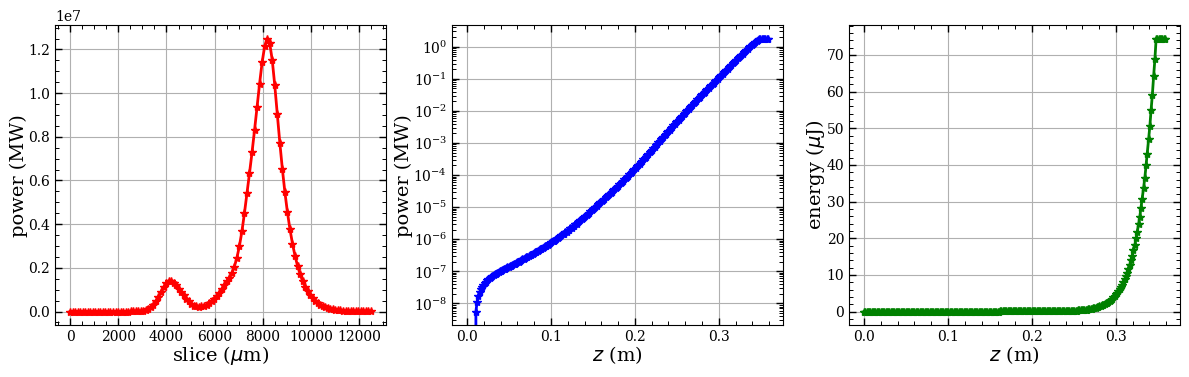

In [56]:
power = np.loadtxt('power.txt')

col = -1
power0 = gen2power(power, lam_s, lam_u, delz, col = col); print power0.shape
#np.savetxt('power0.txt', power1, fmt='%12.4E')

nz, nslice = int(Nu/delz), len(power[:,col])
period_s = lam_s/g_c
time = np.arange(nslice)*period_s*g_c*1e6 # um
# pos = np.arange(nz+1)*lam_u*delz

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
axes[0].plot(time, power[:,col], 'r*-')
axes[0].set_xlabel(r'slice ($\mu$m)')
axes[0].set_ylabel(r'power (MW)')

zpos    = power0[:,0]
power1  = power0[:,1]
energy  = power0[:,2]; print energy[-1]

axes[1].plot(zpos, power1, 'b*-') # energy: MW
axes[1].set_xlabel(r'$z$ (m)')
axes[1].set_ylabel(r'power (MW)')
axes[1].set_yscale('log')

axes[2].plot(zpos, energy, 'g*-') # energy: uJ
axes[2].set_xlabel(r'$z$ (m)')
axes[2].set_ylabel(r'energy ($\mu$J)')

axes[0].grid()
axes[1].grid()
axes[2].grid()

## Radiation spectrum

In [47]:
amp = np.loadtxt('amp.txt')
phase = np.loadtxt('phase.txt')

spectrum = gen2spectrum(phase, amp, lam_s)
np.savetxt('spectrum.txt', spectrum, fmt='%12.4E')

(180L, 1L) (180L, 227L)


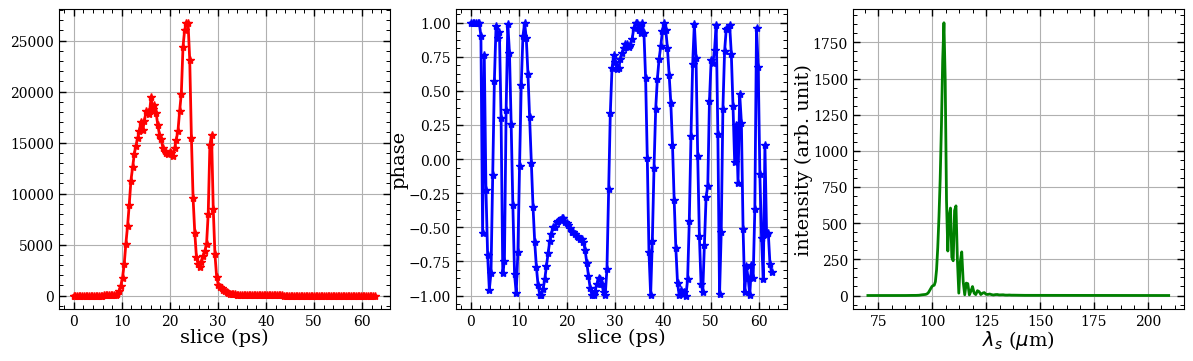

In [48]:
col = -1
nz, nslice = int(Nu/delz), len(power[:,col])
period_s = lam_s/g_c; freq_s = 1./period_s
time = np.arange(nslice)*period_s*1e12 # ps

N = nslice 
a1 = amp[:,col]
p1 = np.cos(phase[:,col])

F = spectrum[:,0]
X = spectrum[:,col]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
axes[0].plot(time, a1, 'r*-')
axes[0].set_xlabel(r'slice (ps)')
axes[1].set_ylabel(r'amplitude')

axes[1].plot(time, p1, 'b*-')
axes[1].set_xlabel(r'slice (ps)')
axes[1].set_ylabel(r'phase')

axes[2].plot(F, X/1e4, 'g-')
axes[2].set_xlabel(r'$\lambda_s$ ($\mu$m)')
axes[2].set_ylabel(r'intensity (arb. unit)')
#axes[2].set_xlim(100, 125)

axes[0].grid()
axes[1].grid()
axes[2].grid()

## Slice parameters

In [57]:
current = np.loadtxt('current.txt'); print current.shape

xrms = np.loadtxt('xrms.txt'); print xrms.shape
std_x = np.zeros(xrms.shape[1])
for i in np.arange(xrms.shape[1]):
    std_x[i] = np.sqrt(np.sum(xrms[:,i]*xrms[:,i]*current[:,1])/np.sum(current[:,1]))

xrms = np.loadtxt('yrms.txt'); print xrms.shape
std_y = np.zeros(xrms.shape[1])
for i in np.arange(xrms.shape[1]):
    std_y[i] = np.sqrt(np.sum(xrms[:,i]*xrms[:,i]*current[:,1])/np.sum(current[:,1]))

(120L, 2L)
(120L, 240L)
(120L, 240L)


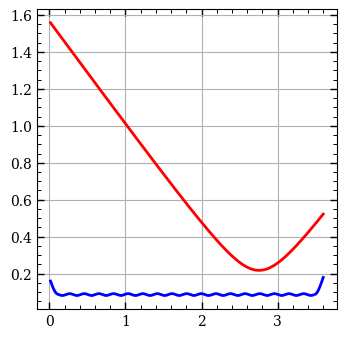

In [58]:
fig, ax = plt.subplots()

zpos = np.linspace(0, 3.6, len(std_x)+1)[1:]

np.savetxt('xy_rms-z.dat', np.array([zpos, std_x*1e3, std_y*1e3]).T, fmt = '%15.6E')
ax.plot(zpos, std_x*1e3, '-')
ax.plot(zpos, std_y*1e3, '-')
ax.grid()

## Batch processing

In [231]:
def readdata(fname):
    data=open(fname, 'r')
    line=data.readline()
    
    kv = {}
    
    while True:
        if not line:
            break
#         keys = {'aw0', 'xlamd', 'xlams', 'npart', 'nslice', 'ntail', }
#         for key in keys:
#             match = re.search(r' '+key, line)
#             if match:
#                 num = re.search(r'[-+]?[0-9]*\.?[0-9]+([eED][-+]?[0-9]+)?',line)
#                 if num:
#                     t = np.float(num.group().replace("D", "E"))
#                     kv.update({key:t})
#                     print line
#                     print key, ' = ', t
        
        match = re.search(r'^[^=]*=[^=]*$' , line)
        if match:
            # print line
            key, value = line.split('=')
            match = re.search(r'file', key)
            if match:
                kv.update({key.strip():value})
                line=data.readline()
                continue
            
            if len(value.split()) == 1:
                value = np.float(value.replace("D", "E"))
            else:
                value = [np.float(v.replace("D", "E")) for v in value.split()]
            kv.update({key.strip():value})          
    
        match = re.search(r'^[ ]*z\[m\][ ]*aw[ ]*qfld[ ]*$', line)
        if match:
            # print line
            nz = np.int(kv['zstop']/kv['delz']/kv['xlamd'])+1
            field = np.zeros((nz, 3))
            for i in np.arange(nz):
                line = data.readline()
                field[i] = np.array([np.float(v.replace("D", "E")) for v in line.split()])
            break
        line=data.readline()
    
    nt = np.int(kv['nslice'])
    nc = np.int(np.sum(kv['lout'])); print nc
    
    current = np.zeros((nt, 2))
    results = np.zeros((nt, nz, nc)); print results.shape
    
    islice = 0
    while True:
        if not line:
            break
        match = re.search(r'[ E]* current', line)
        if match:
            icurrent, tmp = line.split()
            icurrent = np.float(icurrent)
            current[islice, 0] = islice+1; current[islice, 1] = icurrent
            
            
            line = data.readline()
            line = data.readline()
            line = data.readline()
            
            outputs = line.split()
            
            for j in np.arange(nz):
                line = data.readline(); #print line
                results[islice, j] = np.array([np.float(v.replace("D", "E")) for v in line.split()])
            #break
            islice += 1
        line = data.readline()
    
    return
readdata('pithz.1.out')

10
(150L, 301L, 10L)
[[  1.       0.    ]
 [  2.       9.1376]
 [  3.      18.275 ]
 [  4.      27.413 ]
 [  5.      36.55  ]
 [  6.      45.688 ]
 [  7.      54.826 ]
 [  8.      63.561 ]
 [  9.      71.836 ]
 [ 10.      76.107 ]
 [ 11.      80.188 ]
 [ 12.      84.784 ]
 [ 13.      92.127 ]
 [ 14.      99.956 ]
 [ 15.     103.91  ]
 [ 16.     110.5   ]
 [ 17.     115.41  ]
 [ 18.     123.19  ]
 [ 19.     124.8   ]
 [ 20.     134.85  ]
 [ 21.     138.6   ]
 [ 22.     142.21  ]
 [ 23.     143.4   ]
 [ 24.     152.36  ]
 [ 25.     150.29  ]
 [ 26.     153.64  ]
 [ 27.     159.63  ]
 [ 28.     162.51  ]
 [ 29.     161.22  ]
 [ 30.     169.36  ]
 [ 31.     170.69  ]
 [ 32.     170.66  ]
 [ 33.     169.04  ]
 [ 34.     176.59  ]
 [ 35.     178.    ]
 [ 36.     178.47  ]
 [ 37.     182.07  ]
 [ 38.     177.82  ]
 [ 39.     183.31  ]
 [ 40.     181.66  ]
 [ 41.     183.4   ]
 [ 42.     189.37  ]
 [ 43.     181.95  ]
 [ 44.     187.31  ]
 [ 45.     189.5   ]
 [ 46.     187.93  ]
 [ 47.     18

In [11]:
def gen_sum1(col = 0, workdir = './'):
    '''Collect the col-th collumn of all the files under workdir into a 2D array and return it'''
    flag = 0
    for rt, dirs, files in os.walk(workdir):
        for f in files:
            snum = re.match(r'slice_[\d]+.txt', f)
            if snum:
                fname = workdir+os.sep+f; #print fname
                data = np.genfromtxt(fname, skip_header = 5, usecols = (col, col+1),\
                                     invalid_raise = False, filling_values = 0, missing_values = 0)
                tmp = reform(data[:,0]); #print flag, len(tmp)
                if flag == 0:
                    rr = tmp; flag += 1
                else:
                    rr = np.concatenate((rr, tmp), axis = 0); flag += 1
    return rr.reshape((len(rr)/flag, flag))
def gen_sum(col=0,workdir='./'):
    '''Collect the col-th collumn of all the files under workdir into a 2D array and return it'''
    rr=[]
    for rt, dirs, files in os.walk(workdir):
        for f in files:
            #print f
            snum=re.match(r'slice_[\d]+.txt',f)
            if snum:
                fname=workdir+os.sep+f
                data=np.genfromtxt(fname,skip_header=6,usecols=(col,col+1),invalid_raise=False,filling_values=0,missing_values=0)
                tmp=reform(data[:,0])
                rr.append(tmp)
    return rr
def gen2power(power, lam_s, lam_u, delz, col = -1, N = 0):
    '''
    Calculate the radiation power and energy
    Parameters
      power: radiation power in shape of (nt, nz). nt corresponds to slices along the bunch; 
             nz corresponds to bunches along the undulator
      lam_s: radiation wavelength, which is used in Genesis 1.3 simulation
      lam_u: undulator wavelength
      delz:  step used in Genesis 1.3 simulation
    Returns
      An ndarray of (nz, 3), storing the positions, powers and energies of the radiation along the undulator
    '''
    power = np.atleast_2d(power)
    
    nt, nz = power.shape; # print nt, nz
    if N>nt:
        nt = N
    
    period_s = lam_s/g_c
    
    power1 = np.zeros((nz, 3))
    power1[:,0] = np.arange(nz)*lam_u*delz
    power1[:,1] = np.array(power.sum(axis=0)/1e6/nt)
    power1[:,2] = np.array(power.sum(axis=0)*period_s*1e6)
    
    return power1
def gen2spectrum(phase, amp, lam_s, col = -1, N = 0):
    '''
    Calculate the radiation spectrum
    Parameters
      phase and amp: the phases and amplitudes of the radiation pulses
    Returns
      spectrum: the spectrums of each radiation pulse
    '''
    # nt corresponds to slices along the bunch
    # nz corresponds to bunches along the undulator
    amp = np.atleast_2d(amp)
    phase = np.atleast_2d(phase)
    
    nt, nz = amp.shape 
    if N>nt:
        nt = N

    signal = np.zeros(nt, dtype = complex)
    for i in np.arange(nt):
        signal[i] = np.sqrt(amp[i,col])*np.complex(np.cos(phase[i,col]), np.sin(phase[i,col]))
            
    spectrum = np.abs(fftshift(fft(signal, nt)))
    spectrum = spectrum*spectrum

    period_s = lam_s/g_c; freq_s = 1./period_s
    F = 1.0*np.arange(-nt/2, nt/2,)/nt*freq_s+freq_s # Frequency
    F = g_c/F*1e6 # Frequency to wavelength
    
    spec = np.zeros((nt, 2)); #print spec.shape
    spec[:,0] = F; spec[:,1] = spectrum
    return spec
def remove_files(file_list):
    for ff in file_list:
        if os.path.exists(ff):
            os.remove(ff)

In [14]:
print lam_s, lam_u, delz

0.0001048467243452594 0.03 0.5


In [13]:
workdir = simdir + r'/MK-LCLS-I'
os.chdir(workdir)

ext = '-01.txt'
#remove_files(['power-z-ipseed'+ext, 'energy-z-ipseed'+ext, 'spectrum-t-ipseed'+ext])
for i in np.arange(101, 901):
    ipseed = i+1100
    fname = 'pithz.'+`ipseed`
    slice_dir = fname; #print slice_dir
    #gen_split(fname+'.out', slice_dir)

    col = -1
    
    power0 = gen_sum(0, slice_dir); #print power0.shape
    res = gen2power(power0, lam_s, lam_u, delz, col = col)
    if i == 1:
        #print ipseed
        with open('./power-z-ipseed'+ext, 'a') as f_handle:
            np.savetxt(f_handle,np.atleast_2d(res[:,0]),fmt='%15.6E')
        with open('./energy-z-ipseed'+ext, 'a') as f_handle:
            np.savetxt(f_handle,np.atleast_2d(res[:,0]),fmt='%15.6E')
    with open('./power-z-ipseed'+ext, 'a') as f_handle:
        np.savetxt(f_handle,np.atleast_2d(res[:,1]),fmt='%15.6E')
    with open('./energy-z-ipseed'+ext, 'a') as f_handle:
        np.savetxt(f_handle,np.atleast_2d(res[:,2]),fmt='%15.6E')
    
#     amp   = gen_sum(2, slice_dir)
#     phase = gen_sum(3, slice_dir)
#     res = gen2spectrum(phase, amp, lam_s, col)
#     if ipseed == 1:
#         print ipseed
#         with open('./spectrum-t-ipseed'+ext, 'a') as f_handle:
#             np.savetxt(f_handle,np.atleast_2d(res[:,0]),fmt='%15.6E')
#     with open('./spectrum-t-ipseed'+ext, 'a') as f_handle:
#         np.savetxt(f_handle,np.atleast_2d(res[:,1]),fmt='%15.6E')

(226L, 2001L)
(226L, 2001L)
P =:  7.6136107916 +/- 3.6445523997833242  MW
E =:  319.525911725 +/- 152.95356795652256  uJ


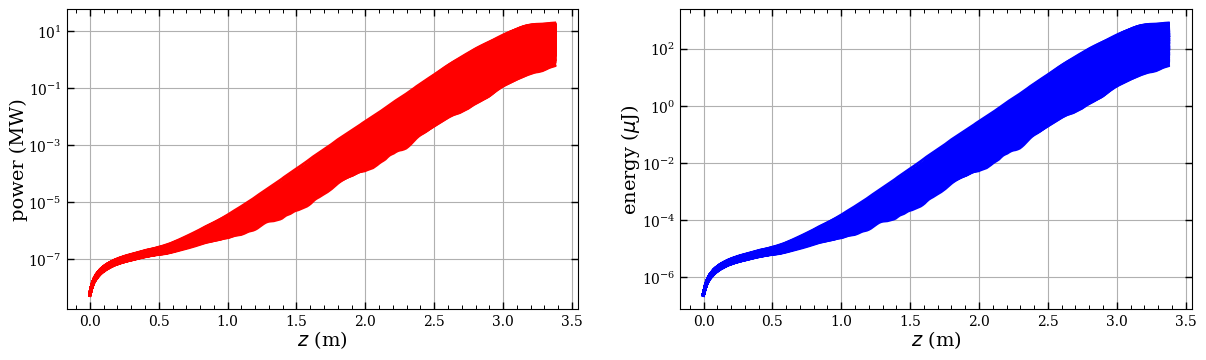

In [26]:
workdir = simdir + r'/MK-LCLS-I'
os.chdir(workdir)

pp = np.loadtxt('power-z-ipseed-2k.txt'); pp = pp.T; print pp.shape
EE = np.loadtxt('energy-z-ipseed-2k.txt'); EE = EE.T; print EE.shape

end = 2001
print 'P =: ', np.mean(pp[-1,1:end]), '+/-', np.std(pp[-1,1:end]), ' MW'
print 'E =: ', np.mean(EE[-1,1:end]), '+/-', np.std(EE[-1,1:end]), ' uJ'

fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

for i in np.arange(1, end):

    ax1.plot(pp[:,0], pp[:,i], 'r-') # energy: MW  
    ax2.plot(EE[:,0], EE[:,i], 'b-') # energy: uJ

ax1.set_xlabel(r'$z$ (m)')
ax1.set_ylabel(r'power (MW)')
ax1.set_yscale('log')
ax1.grid()

ax2.set_xlabel(r'$z$ (m)')
ax2.set_ylabel(r'energy ($\mu$J)')
ax2.set_yscale('log')
ax2.grid()

In [ ]:
samples = np.loadtxt('samples-2k.txt')
ratio = samples[:,1]
energ = EE[-1,1:]; print np.mean(energ), np.std(energ)

fig, ax = plt.subplots(figsize = (5, 4))
ax.plot(ratio*100*1.5088, energ/440., '.')

f = lambda x, a: np.exp(-a*x**2)
#f = lambda x, b: 1+b*x

popt, pcov = curve_fit(f, ratio*100, energ/440)
rr = np.linspace(0, 2, 101)
ax.plot(rr*1.5088, f(rr, *popt), '-')
ax.set_xlabel(r'$\Delta B/B$ (%)')
ax.set_ylabel(r'$P/P_0$')
ax.grid()
ax.legend('')
#fig.savefig('power-del_B-ipseed.eps')

In [213]:
workdir = simdir + r'/MK-LCLS-I'
os.chdir(workdir)

res = []
for i in np.arange(1, 1001):
    ipseed = i
    fname = 'pithz.'+`ipseed`+'.txt'
    data = np.loadtxt(fname)
    res.append([i, np.std(data[:,1]), np.sqrt(np.mean(data[:,1]**2))])

1.5088762001783553


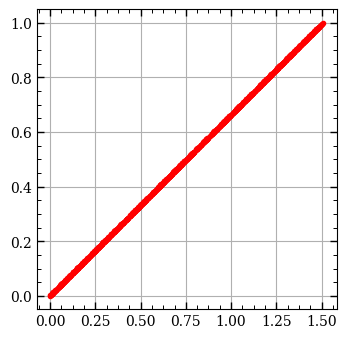

In [220]:
res = np.array(res)
fig, ax = plt.subplots()
ax.plot((res[:,1]/Ku*100), ratio*100, '.')
ax.grid()
print np.mean(res[:,1]/Ku/ratio)

In [190]:
print np.sqrt(1/12.)*2

0.5773502691896257


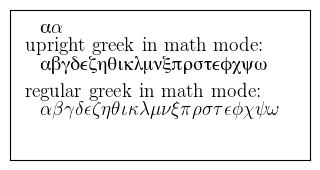

In [57]:
from matplotlib import rc, pyplot
 
rc('text', usetex=True)
rc('text.latex', preamble = ','.join('''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
rc('font', family='serif', weight='normal', style='normal')


fig = pyplot.figure(figsize=(4,2))
ax = fig.add_subplot(1,1,1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

gchars = ''' alpha beta gamma delta epsilon zeta eta theta iota
 kappa lambda mu nu xi pi rho sigma tau epsilon phi chi psi omega
 '''.split()

ax.text(0.05,0.72, r'upright greek in math mode:')
ax.text(0.1,0.6, '$'+ ' '.join(['\\'+c+'up' for c in gchars]) +'$')

ax.text(0.1,0.85, '$\\alphaup\\alpha$')

ax.text(0.05,0.42, r'regular greek in math mode:')
ax.text(0.1,0.3, '$'+ ' '.join(['\\'+c for c in gchars]) +'$')

pyplot.show()